# Постановка задачи
Имеем два набора данных: x_pb и x_nup, со свойствами композитов.
Объединение необходимо произвести по типу INNER: ETL = получение, очистка, совмещение данных.
Необходимо:
1. Провести разведочный анализ предложенных данных. Необходимо нарисовать гистограммы распределения каждой из переменной, диаграммы ящика с усами, попарные графики рассеяния точек. Необходимо также для каждой колонке получить среднее, медианное значение, провести анализ и исключение выбросов, проверить наличие пропусков.
2. Провести предобработку данных (удаление шумов, нормализация и т.д.).
3. Обучить нескольких моделей для прогноза модуля упругости при растяжении и прочности при растяжении. При построении модели необходимо 30% данных оставить на тестирование модели, на остальных происходит обучение моделей. При построении моделей провести поиск гиперпараметров модели с помощью поиска по сетке с перекрестной проверкой, количество блоков равно 10.
4. Написать нейронную сеть, которая будет рекомендовать соотношение матрица-наполнитель.
5. Разработать приложение с графическим интерфейсом или интерфейсом командной строки, которое будет выдавать прогноз, полученный в задании 4 или 5.
6. Оценить точность модели на тренировочном и тестовом датасете.
7. Создать репозиторий в GitHub / GitLab и разместить там код исследования. Оформить файл README.


### Подключение библиотек

In [1]:
import numpy as np #для матричных операций
np.set_printoptions(precision=3, suppress=True)
import pandas as pd #для загрузки данных
import matplotlib.pyplot as plt #для графиков
import seaborn as sns #для отрисовки графиков

In [2]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder #
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from pandas.plotting import scatter_matrix

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### Загрузка данных

In [4]:
df_bp = pd.read_excel(r"C:\Users\juiry\Documents\VKR\X_bp.xlsx", index_col=0)
df_nup = pd.read_excel(r"C:\Users\juiry\Documents\VKR\X_nup.xlsx", index_col=0)

df = df_bp.merge(df_nup, left_index=True,right_index=True, how='inner')

In [5]:
df

Соотношение матрица-наполнитель  Плотность, кг/м3  \
0.0                            1.857143       2030.000000   
1.0                            1.857143       2030.000000   
2.0                            1.857143       2030.000000   
3.0                            1.857143       2030.000000   
4.0                            2.771331       2030.000000   
...                                 ...               ...   
1018.0                         2.271346       1952.087902   
1019.0                         3.444022       2050.089171   
1020.0                         3.280604       1972.372865   
1021.0                         3.705351       2066.799773   
1022.0                         3.808020       1890.413468   

        модуль упругости, ГПа  Количество отвердителя, м.%  \
0.0                738.736842                    30.000000   
1.0                738.736842                    50.000000   
2.0                738.736842                    49.900000   
3.0                738.736842                   129.000000   
4.0                753.000000                   111.860000   
...                       ...                          ...   
1018.0             912.855545                    86.992183   
1019.0             444.732634                   145.981978   
1020.0             416.836524                   110.533477   
1021.0             741.475517                   141.397963   
1022.0             417.316232                   129.183416   

        Содержание эпоксидных групп,%_2  Температура вспышки, С_2  \
0.0                           22.267857                100.000000   
1.0                           23.750000                284.615385   
2.0                           33.000000                284.615385   
3.0                           21.250000                300.000000   
4.0                           22.267857                284.615385   
...                                 ...                       ...   
1018.0                        20.123249                324.774576   
1019.0                        19.599769                254.215401   
1020.0                        23.957502                248.423047   
1021.0                        19.246945                275.779840   
1022.0                        27.474763                300.952708   

        Поверхностная плотность, г/м2  Модуль упругости при растяжении, ГПа  \
0.0                        210.000000                             70.000000   
1.0                        210.000000                             70.000000   
2.0                        210.000000                             70.000000   
3.0                        210.000000                             70.000000   
4.0                        210.000000                             70.000000   
...                               ...                                   ...   
1018.0                     209.198700                             73.090961   
1019.0                     350.660830                             72.920827   
1020.0                     740.142791                             74.734344   
1021.0                     641.468152                             74.042708   
1022.0                     758.747882                             74.309704   

        Прочность при растяжении, МПа  Потребление смолы, г/м2  \
0.0                       3000.000000               220.000000   
1.0                       3000.000000               220.000000   
2.0                       3000.000000               220.000000   
3.0                       3000.000000               220.000000   
4.0                       3000.000000               220.000000   
...                               ...                      ...   
1018.0                    2387.292495               125.007669   
1019.0                    2360.392784               117.730099   
1020.0                    2662.906040               236.606764   
1021.0                    2071.715856               197.126067   
1022.0                    

In [6]:
df.shape

(1023, 13)

# Разведочный анализ данных

### Проверка наличия пропусков в данных

In [7]:
df.isna().sum()

Соотношение матрица-наполнитель         0
Плотность, кг/м3                        0
модуль упругости, ГПа                   0
Количество отвердителя, м.%             0
Содержание эпоксидных групп,%_2         0
Температура вспышки, С_2                0
Поверхностная плотность, г/м2           0
Модуль упругости при растяжении, ГПа    0
Прочность при растяжении, МПа           0
Потребление смолы, г/м2                 0
Угол нашивки, град                      0
Шаг нашивки                             0
Плотность нашивки                       0
dtype: int64

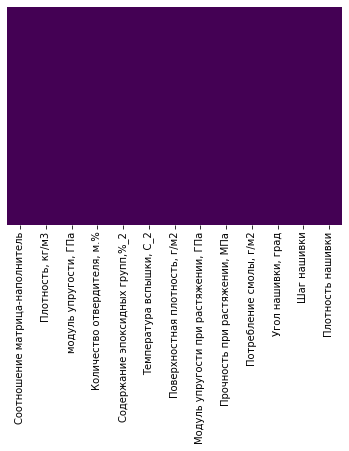

In [8]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis');

**Вывод: пропуски данных отсутствуют**

### Кодируем угол нашивки в LabelEncoder

In [9]:
le = LabelEncoder()
df['Угол нашивки, град'] = le.fit_transform(df['Угол нашивки, град'])
df

Соотношение матрица-наполнитель  Плотность, кг/м3  \
0.0                            1.857143       2030.000000   
1.0                            1.857143       2030.000000   
2.0                            1.857143       2030.000000   
3.0                            1.857143       2030.000000   
4.0                            2.771331       2030.000000   
...                                 ...               ...   
1018.0                         2.271346       1952.087902   
1019.0                         3.444022       2050.089171   
1020.0                         3.280604       1972.372865   
1021.0                         3.705351       2066.799773   
1022.0                         3.808020       1890.413468   

        модуль упругости, ГПа  Количество отвердителя, м.%  \
0.0                738.736842                    30.000000   
1.0                738.736842                    50.000000   
2.0                738.736842                    49.900000   
3.0                738.736842                   129.000000   
4.0                753.000000                   111.860000   
...                       ...                          ...   
1018.0             912.855545                    86.992183   
1019.0             444.732634                   145.981978   
1020.0             416.836524                   110.533477   
1021.0             741.475517                   141.397963   
1022.0             417.316232                   129.183416   

        Содержание эпоксидных групп,%_2  Температура вспышки, С_2  \
0.0                           22.267857                100.000000   
1.0                           23.750000                284.615385   
2.0                           33.000000                284.615385   
3.0                           21.250000                300.000000   
4.0                           22.267857                284.615385   
...                                 ...                       ...   
1018.0                        20.123249                324.774576   
1019.0                        19.599769                254.215401   
1020.0                        23.957502                248.423047   
1021.0                        19.246945                275.779840   
1022.0                        27.474763                300.952708   

        Поверхностная плотность, г/м2  Модуль упругости при растяжении, ГПа  \
0.0                        210.000000                             70.000000   
1.0                        210.000000                             70.000000   
2.0                        210.000000                             70.000000   
3.0                        210.000000                             70.000000   
4.0                        210.000000                             70.000000   
...                               ...                                   ...   
1018.0                     209.198700                             73.090961   
1019.0                     350.660830                             72.920827   
1020.0                     740.142791                             74.734344   
1021.0                     641.468152                             74.042708   
1022.0                     758.747882                             74.309704   

        Прочность при растяжении, МПа  Потребление смолы, г/м2  \
0.0                       3000.000000               220.000000   
1.0                       3000.000000               220.000000   
2.0                       3000.000000               220.000000   
3.0                       3000.000000               220.000000   
4.0                       3000.000000               220.000000   
...                               ...                      ...   
1018.0                    2387.292495               125.007669   
1019.0                    2360.392784               117.730099   
1020.0                    2662.906040               236.606764   
1021.0                    2071.715856               197.126067   
1022.0                    

In [10]:
df.info();

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1023 entries, 0.0 to 1022.0
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Соотношение матрица-наполнитель       1023 non-null   float64
 1   Плотность, кг/м3                      1023 non-null   float64
 2   модуль упругости, ГПа                 1023 non-null   float64
 3   Количество отвердителя, м.%           1023 non-null   float64
 4   Содержание эпоксидных групп,%_2       1023 non-null   float64
 5   Температура вспышки, С_2              1023 non-null   float64
 6   Поверхностная плотность, г/м2         1023 non-null   float64
 7   Модуль упругости при растяжении, ГПа  1023 non-null   float64
 8   Прочность при растяжении, МПа         1023 non-null   float64
 9   Потребление смолы, г/м2               1023 non-null   float64
 10  Угол нашивки, град                    1023 non-null   int64  
 11  Шаг нашивки

### Квартили, среднее, медианное значение для параметров

In [11]:
df.describe()

Соотношение матрица-наполнитель  Плотность, кг/м3  \
count                      1023.000000       1023.000000   
mean                          2.930366       1975.734888   
std                           0.913222         73.729231   
min                           0.389403       1731.764635   
25%                           2.317887       1924.155467   
50%                           2.906878       1977.621657   
75%                           3.552660       2021.374375   
max                           5.591742       2207.773481   

       модуль упругости, ГПа  Количество отвердителя, м.%  \
count            1023.000000                  1023.000000   
mean              739.923233                   110.570769   
std               330.231581                    28.295911   
min                 2.436909                    17.740275   
25%               500.047452                    92.443497   
50%               739.664328                   110.564840   
75%               961.812526                   129.730366   
max              1911.536477                   198.953207   

       Содержание эпоксидных групп,%_2  Температура вспышки, С_2  \
count                      1023.000000               1023.000000   
mean                         22.244390                285.882151   
std                           2.406301                 40.943260   
min                          14.254985                100.000000   
25%                          20.608034                259.066528   
50%                          22.230744                285.896812   
75%                          23.961934                313.002106   
max                          33.000000                413.273418   

       Поверхностная плотность, г/м2  Модуль упругости при растяжении, ГПа  \
count                    1023.000000                           1023.000000   
mean                      482.731833                             73.328571   
std                       281.314690                              3.118983   
min                         0.603740                             64.054061   
25%                       266.816645                             71.245018   
50%                       451.864365                             73.268805   
75%                       693.225017                             75.356612   
max                      1399.542362                             82.682051   

       Прочность при растяжении, МПа  Потребление смолы, г/м2  \
count                    1023.000000              1023.000000   
mean                     2466.922843               218.423144   
std                       485.628006                59.735931   
min                      1036.856605                33.803026   
25%                      2135.850448               179.627520   
50%                      2459.524526               219.198882   
75%                      2767.193119               257.481724   
max                      3848.436732               414.590628   

       Угол нашивки, град  Шаг нашивки  Плотность нашивки  
count         1023.000000  1023.000000        1023.000000  
mean             0.491691     6.899222          57.153929  
std              0.500175     2.563467          12.350969  
min              0.000000     0.000000           0.000000  
25%              0.000000     5.080033          49.799212  
50%              0.000000     6.916144          57.341920  
75%              1.000000     8.586293          64.944961  
max              1.000000    14.440522         103.988901

### Попарные графики рассеяния точек

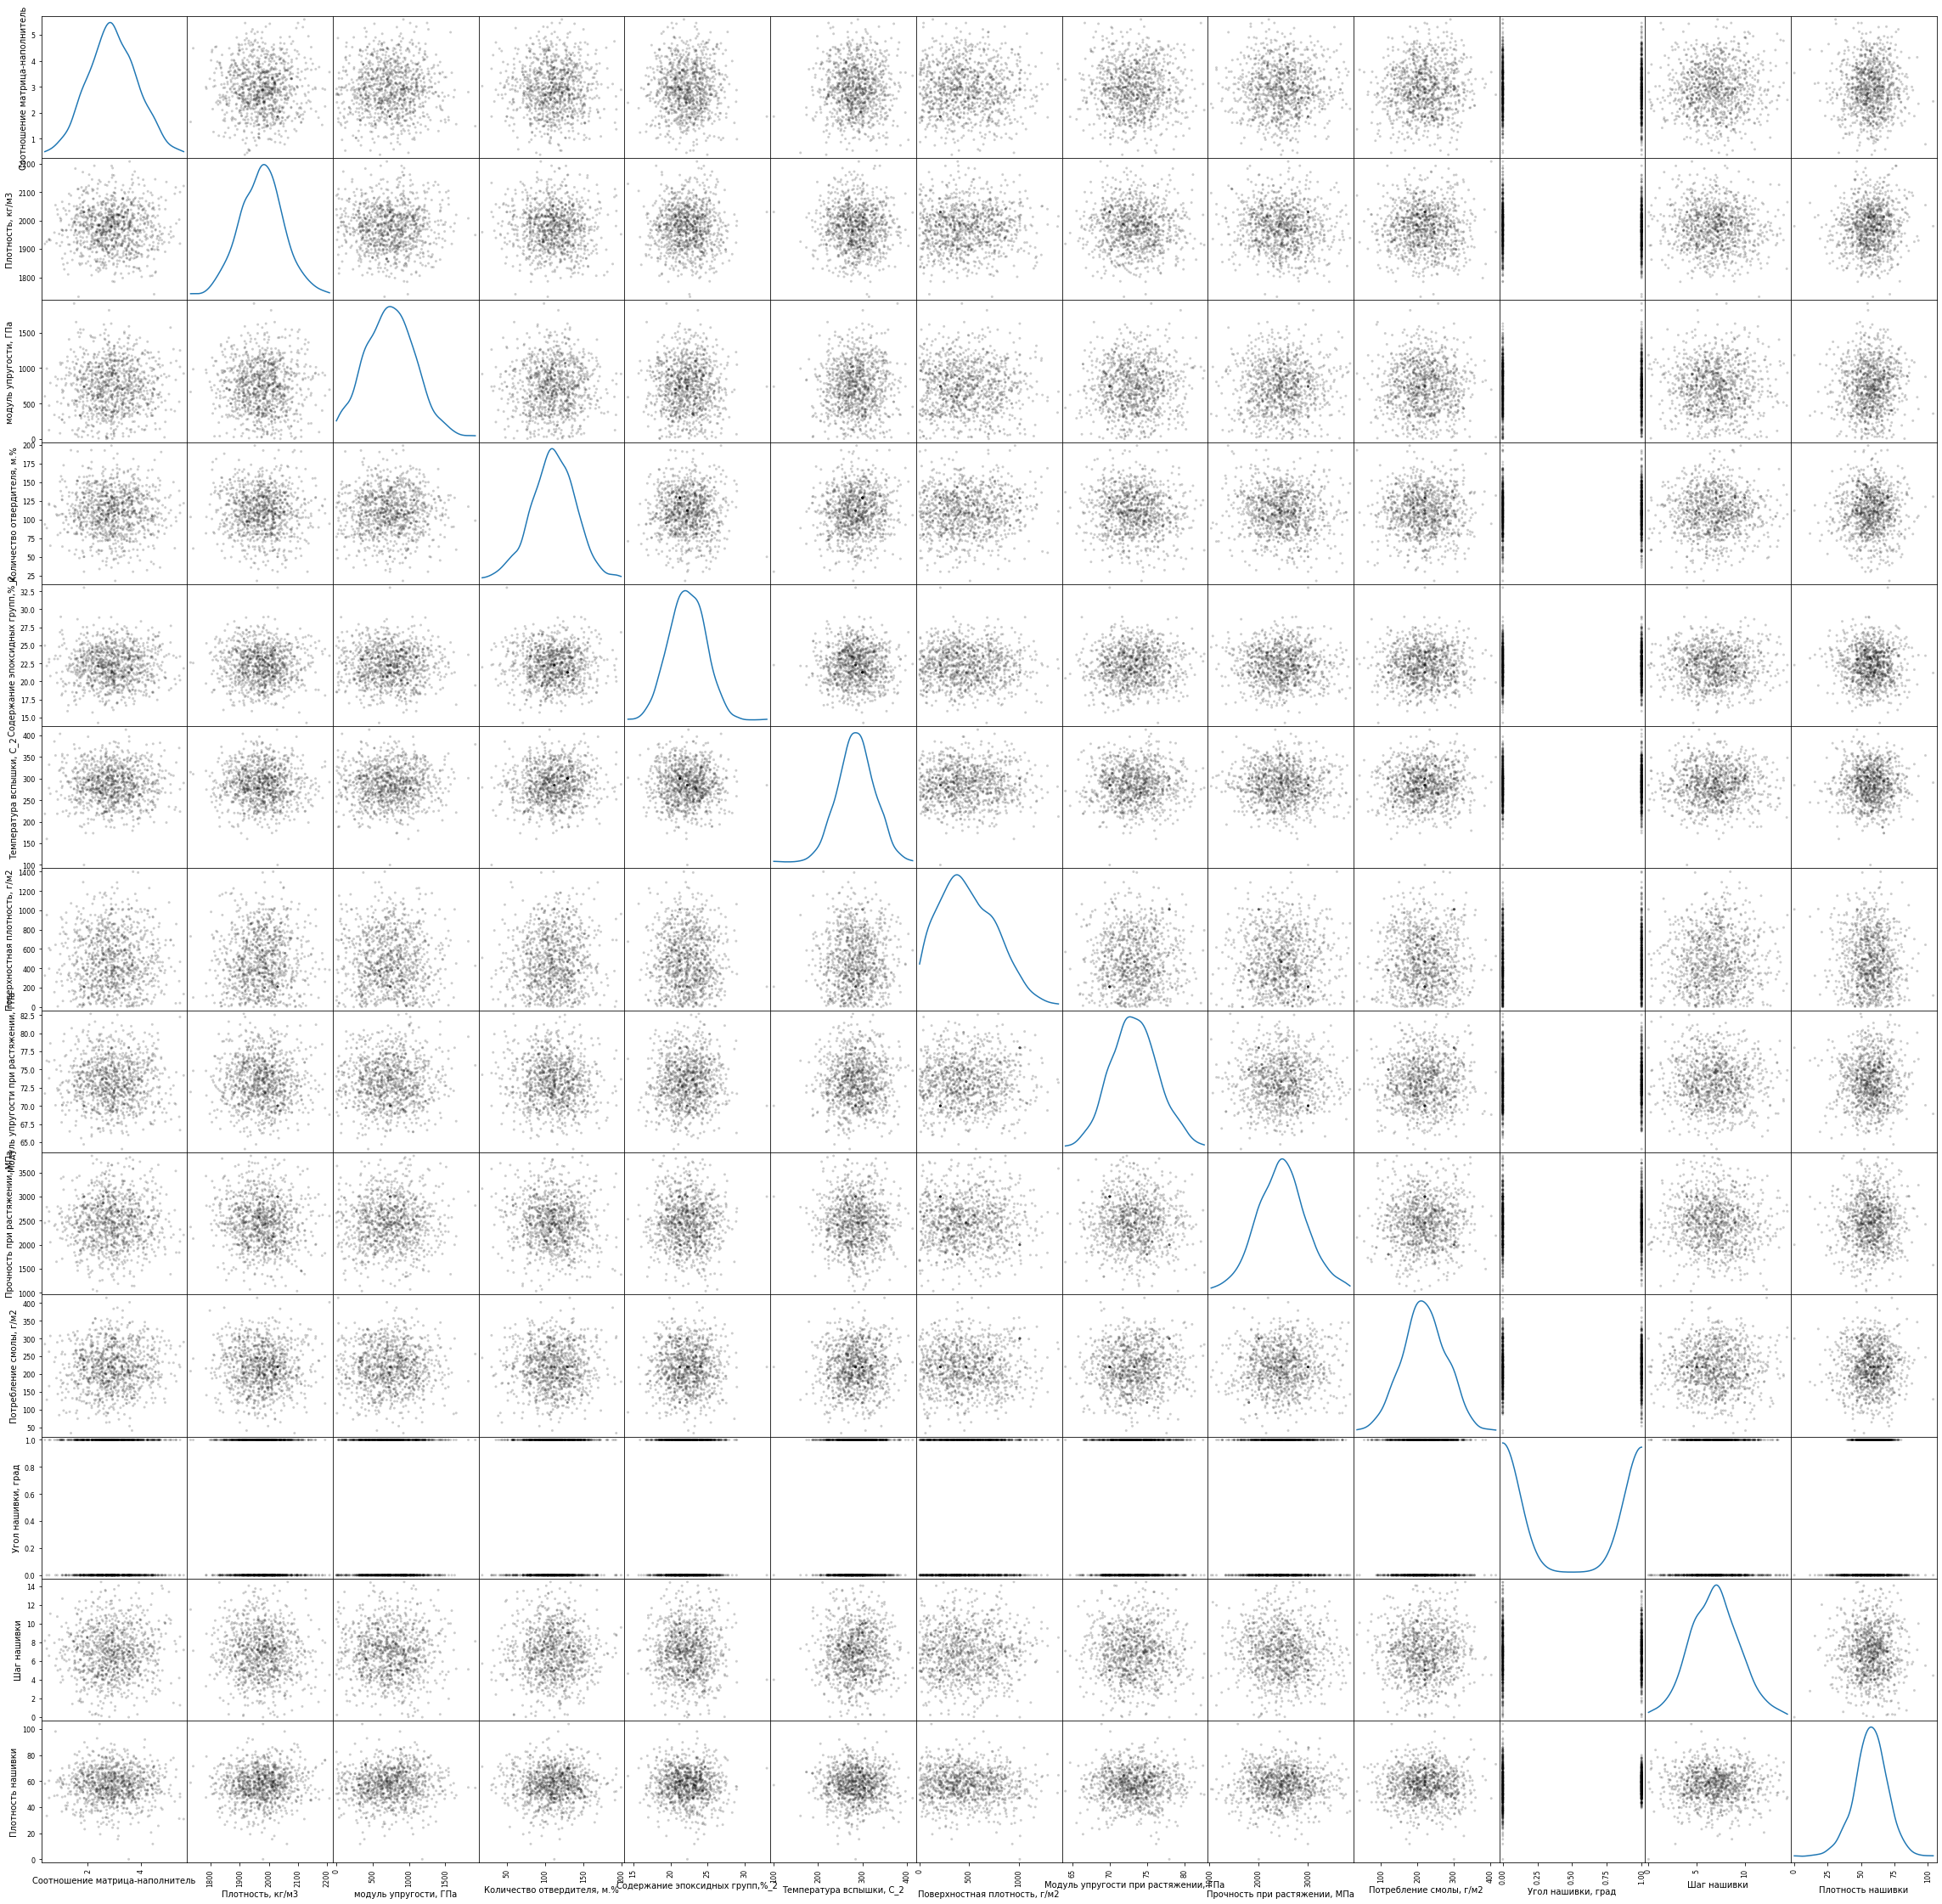

In [12]:
scatter_matrix(df, alpha=0.2, figsize=(40, 40), diagonal='kde', color='black');

**Вывод: данные не имеют четко выраженной зависимости. Регрессионная зависимость слабо выражена. Корреляция слабая. Возможно, здесь сложная нелинейная зависимость или засимость комбинации признаков.**

### **Проверка корреляции признаков**

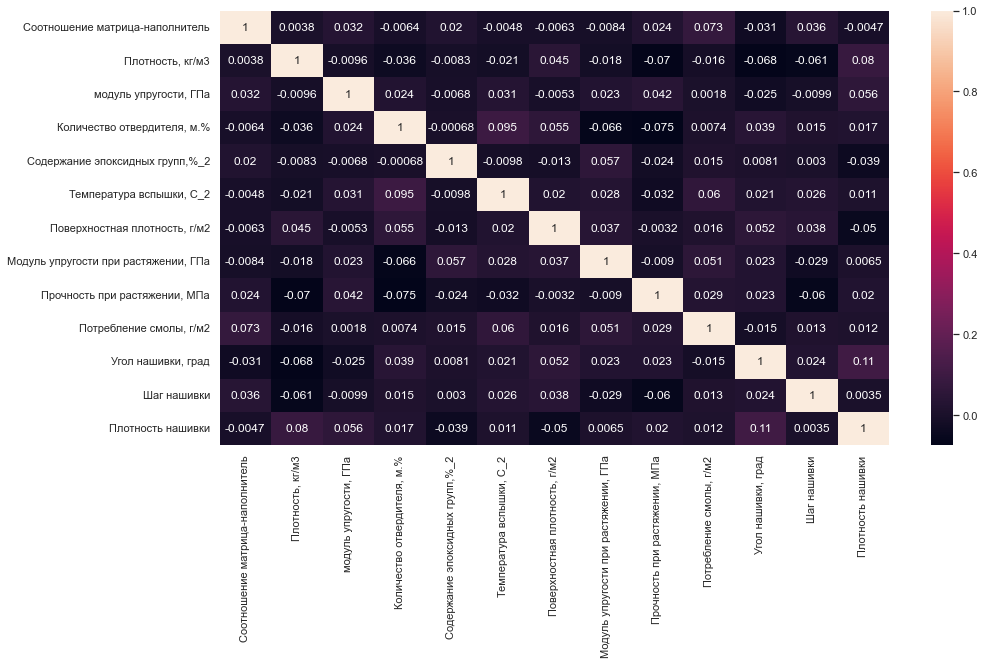

In [13]:
sns.set(rc = {'figure.figsize':(15, 8)})

# Визуализируем данные корреляции
sns.heatmap(df.corr(), annot=True);

**Вывод: корреляция признаков близка к 0, зависимость не линейная.**

### Гистограммы:

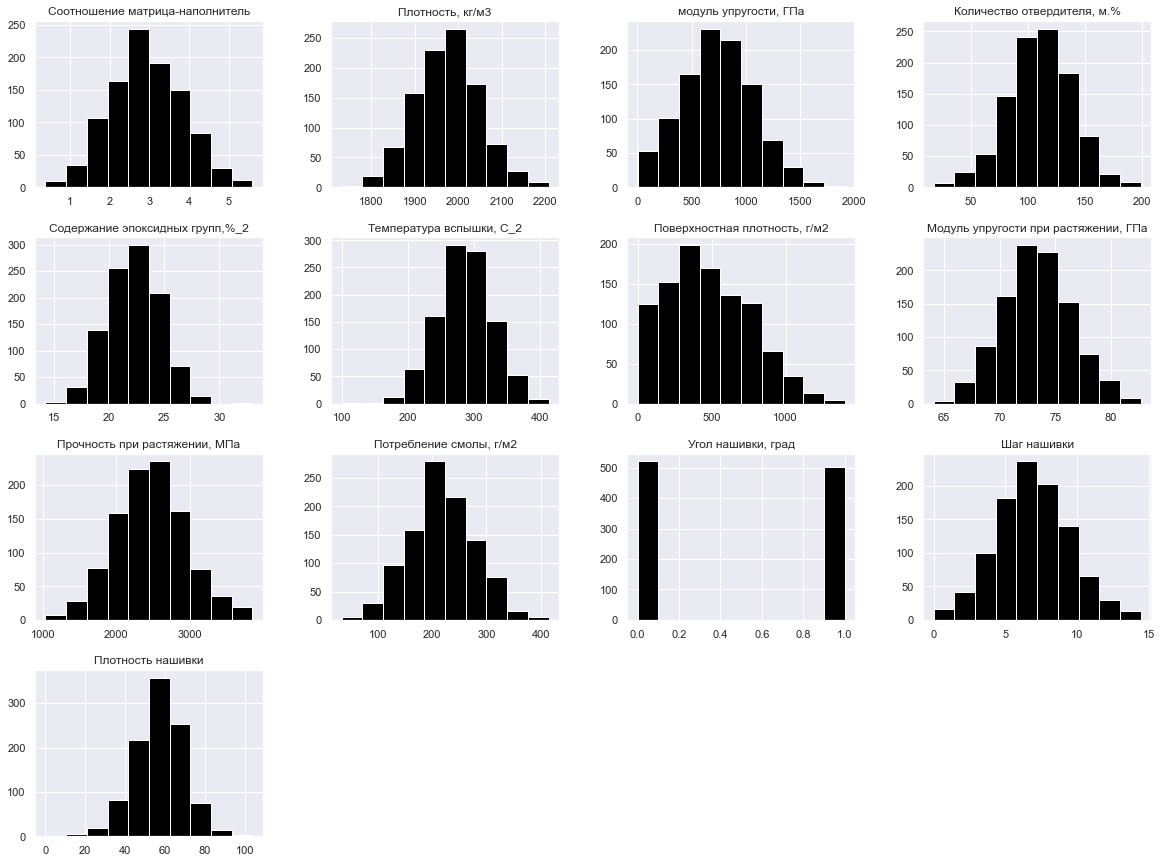

In [14]:
df.hist(figsize=(20,15), color='black');

**Вывод: данные распределены дискретно по параметру "Угол нашивки". Распределение данных по остальным параметрам близко к нормальному распределению.**

### Диаграмма "ящик с усами"

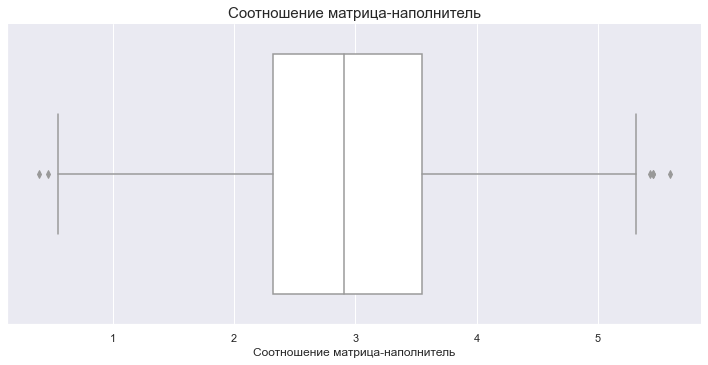

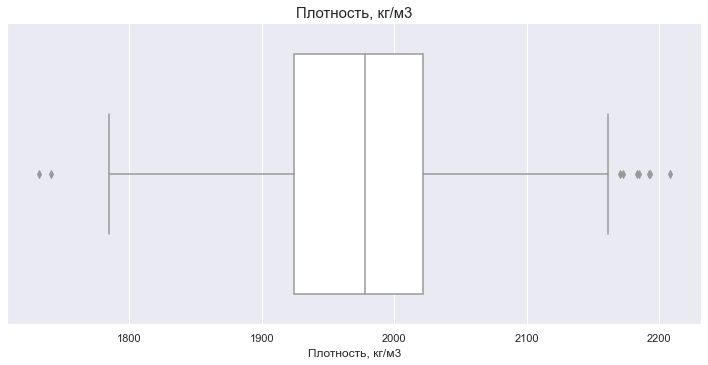

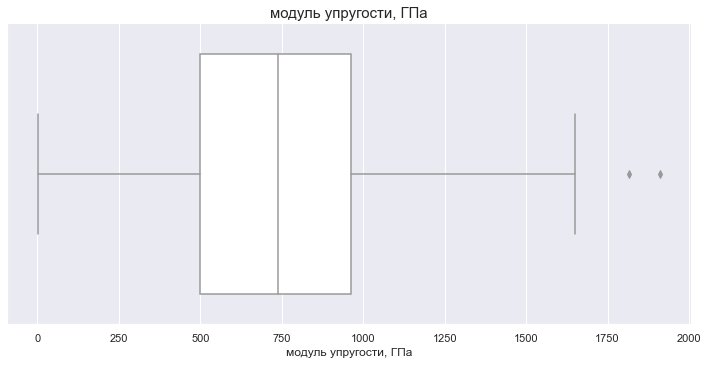

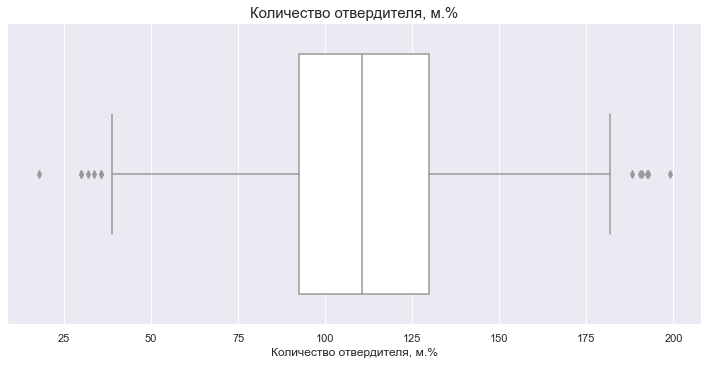

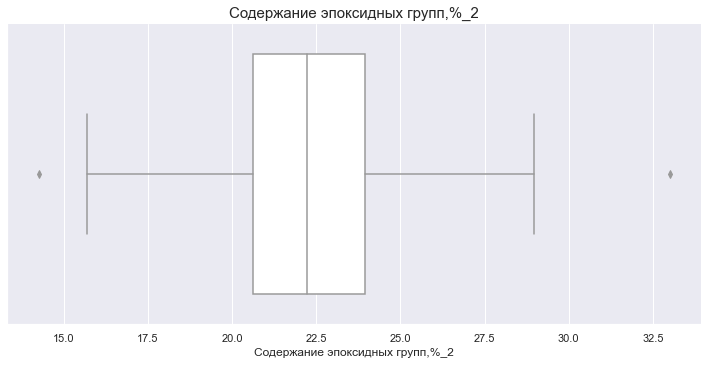

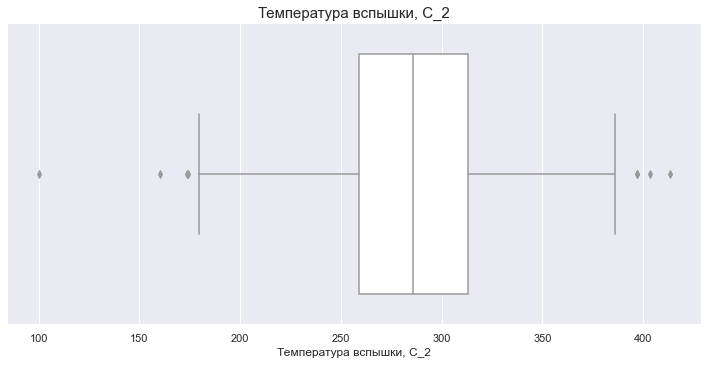

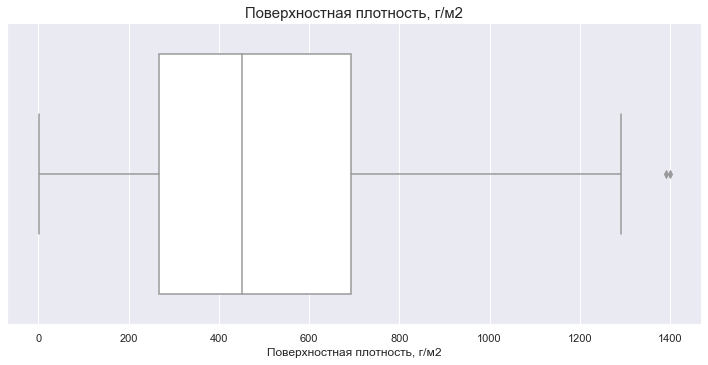

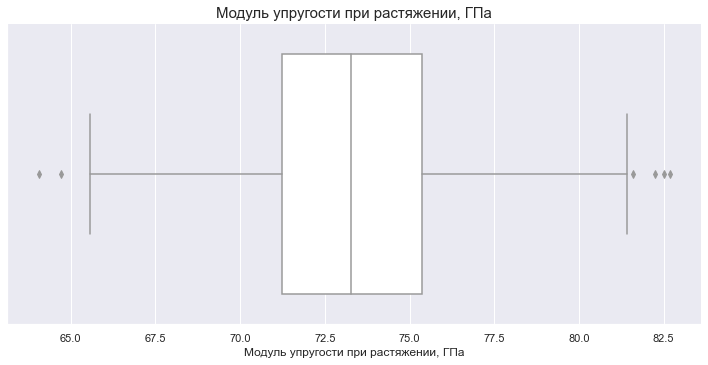

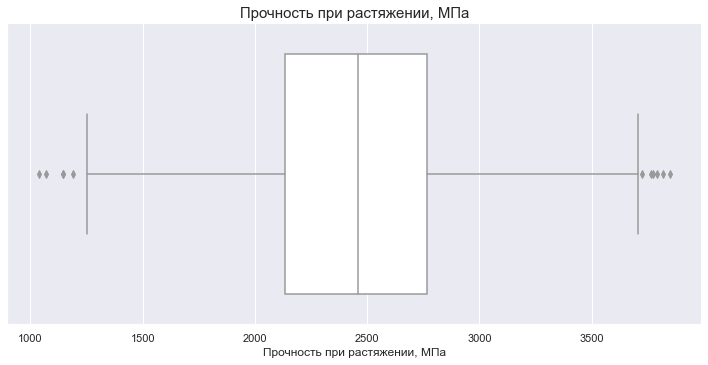

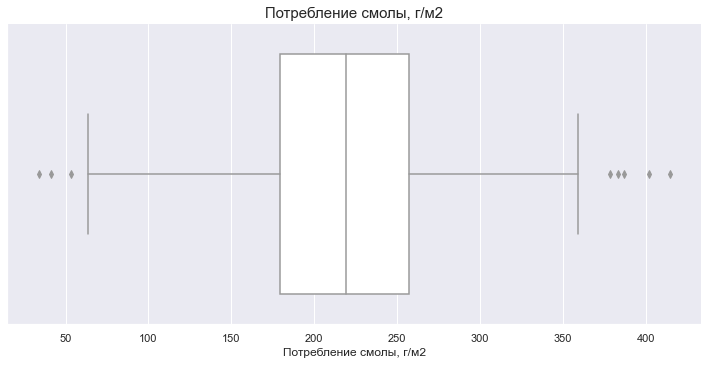

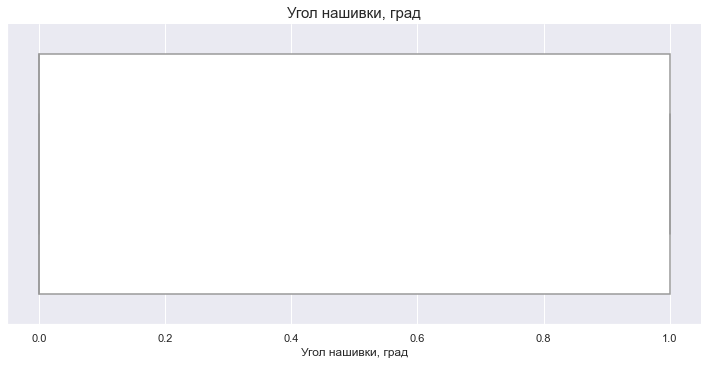

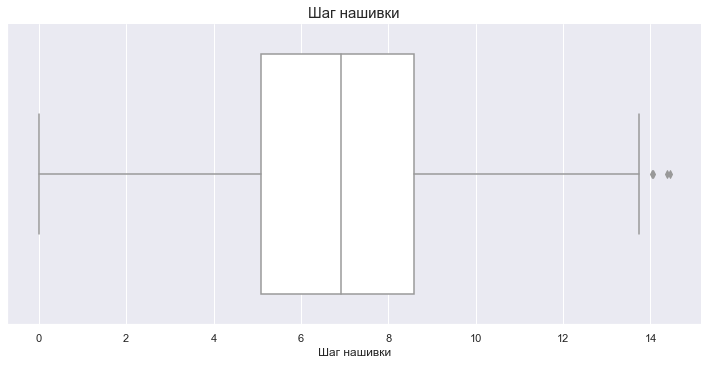

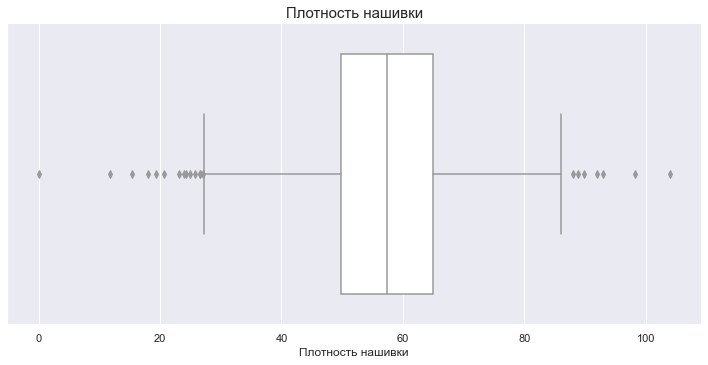

In [15]:
for col in df.columns:
    sns.catplot(x=col, data=df, kind='box', color='white', aspect=1*2)
    plt.title(col, fontsize=15)

**Вывод: имеются выбросы данных**

# Предобработка данных

### Исключение малоинформативных признаков

In [16]:
num_rows = len(df.index)
low_information_cols = []

for col in df.columns:
    cnts = df[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]
    
    if top_pct > 0.95:
        low_information_cols.append(col)
        print('{0}: {1:5f}%'.format(col, top_pct*100))
        print(cnts)
        print()

**Вывод: малоинформативные признаки отсутствуют.**

### Исключение выбросов на основе межквартильного расстояния

In [17]:
for x in df.columns:
    q75,q25 = np.percentile(df.loc[:,x],[75,25])
    intr_qr = q75-q25
    
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
    
    df.loc[df[x] < min,x] = np.nan
    df.loc[df[x] > max,x] = np.nan
    
df.isnull().sum()

Соотношение матрица-наполнитель          6
Плотность, кг/м3                         9
модуль упругости, ГПа                    2
Количество отвердителя, м.%             14
Содержание эпоксидных групп,%_2          2
Температура вспышки, С_2                 8
Поверхностная плотность, г/м2            2
Модуль упругости при растяжении, ГПа     6
Прочность при растяжении, МПа           11
Потребление смолы, г/м2                  8
Угол нашивки, град                       0
Шаг нашивки                              4
Плотность нашивки                       21
dtype: int64

In [18]:
df

Соотношение матрица-наполнитель  Плотность, кг/м3  \
0.0                            1.857143       2030.000000   
1.0                            1.857143       2030.000000   
2.0                            1.857143       2030.000000   
3.0                            1.857143       2030.000000   
4.0                            2.771331       2030.000000   
...                                 ...               ...   
1018.0                         2.271346       1952.087902   
1019.0                         3.444022       2050.089171   
1020.0                         3.280604       1972.372865   
1021.0                         3.705351       2066.799773   
1022.0                         3.808020       1890.413468   

        модуль упругости, ГПа  Количество отвердителя, м.%  \
0.0                738.736842                          NaN   
1.0                738.736842                    50.000000   
2.0                738.736842                    49.900000   
3.0                738.736842                   129.000000   
4.0                753.000000                   111.860000   
...                       ...                          ...   
1018.0             912.855545                    86.992183   
1019.0             444.732634                   145.981978   
1020.0             416.836524                   110.533477   
1021.0             741.475517                   141.397963   
1022.0             417.316232                   129.183416   

        Содержание эпоксидных групп,%_2  Температура вспышки, С_2  \
0.0                           22.267857                       NaN   
1.0                           23.750000                284.615385   
2.0                                 NaN                284.615385   
3.0                           21.250000                300.000000   
4.0                           22.267857                284.615385   
...                                 ...                       ...   
1018.0                        20.123249                324.774576   
1019.0                        19.599769                254.215401   
1020.0                        23.957502                248.423047   
1021.0                        19.246945                275.779840   
1022.0                        27.474763                300.952708   

        Поверхностная плотность, г/м2  Модуль упругости при растяжении, ГПа  \
0.0                        210.000000                             70.000000   
1.0                        210.000000                             70.000000   
2.0                        210.000000                             70.000000   
3.0                        210.000000                             70.000000   
4.0                        210.000000                             70.000000   
...                               ...                                   ...   
1018.0                     209.198700                             73.090961   
1019.0                     350.660830                             72.920827   
1020.0                     740.142791                             74.734344   
1021.0                     641.468152                             74.042708   
1022.0                     758.747882                             74.309704   

        Прочность при растяжении, МПа  Потребление смолы, г/м2  \
0.0                       3000.000000               220.000000   
1.0                       3000.000000               220.000000   
2.0                       3000.000000               220.000000   
3.0                       3000.000000               220.000000   
4.0                       3000.000000               220.000000   
...                               ...                      ...   
1018.0                    2387.292495               125.007669   
1019.0                    2360.392784               117.730099   
1020.0                    2662.906040               236.606764   
1021.0                    2071.715856               197.126067   
1022.0                    

In [19]:
df_clean = df.dropna(axis=0)
df_clean

Соотношение матрица-наполнитель  Плотность, кг/м3  \
1.0                            1.857143       2030.000000   
3.0                            1.857143       2030.000000   
4.0                            2.771331       2030.000000   
5.0                            2.767918       2000.000000   
6.0                            2.569620       1910.000000   
...                                 ...               ...   
1018.0                         2.271346       1952.087902   
1019.0                         3.444022       2050.089171   
1020.0                         3.280604       1972.372865   
1021.0                         3.705351       2066.799773   
1022.0                         3.808020       1890.413468   

        модуль упругости, ГПа  Количество отвердителя, м.%  \
1.0                738.736842                    50.000000   
3.0                738.736842                   129.000000   
4.0                753.000000                   111.860000   
5.0                748.000000                   111.860000   
6.0                807.000000                   111.860000   
...                       ...                          ...   
1018.0             912.855545                    86.992183   
1019.0             444.732634                   145.981978   
1020.0             416.836524                   110.533477   
1021.0             741.475517                   141.397963   
1022.0             417.316232                   129.183416   

        Содержание эпоксидных групп,%_2  Температура вспышки, С_2  \
1.0                           23.750000                284.615385   
3.0                           21.250000                300.000000   
4.0                           22.267857                284.615385   
5.0                           22.267857                284.615385   
6.0                           22.267857                284.615385   
...                                 ...                       ...   
1018.0                        20.123249                324.774576   
1019.0                        19.599769                254.215401   
1020.0                        23.957502                248.423047   
1021.0                        19.246945                275.779840   
1022.0                        27.474763                300.952708   

        Поверхностная плотность, г/м2  Модуль упругости при растяжении, ГПа  \
1.0                        210.000000                             70.000000   
3.0                        210.000000                             70.000000   
4.0                        210.000000                             70.000000   
5.0                        210.000000                             70.000000   
6.0                        210.000000                             70.000000   
...                               ...                                   ...   
1018.0                     209.198700                             73.090961   
1019.0                     350.660830                             72.920827   
1020.0                     740.142791                             74.734344   
1021.0                     641.468152                             74.042708   
1022.0                     758.747882                             74.309704   

        Прочность при растяжении, МПа  Потребление смолы, г/м2  \
1.0                       3000.000000               220.000000   
3.0                       3000.000000               220.000000   
4.0                       3000.000000               220.000000   
5.0                       3000.000000               220.000000   
6.0                       3000.000000               220.000000   
...                               ...                      ...   
1018.0                    2387.292495               125.007669   
1019.0                    2360.392784               117.730099   
1020.0                    2662.906040               236.606764   
1021.0                    2071.715856               197.126067   
1022.0                    

**Так же, попробуем заменить выбросы медианным значением**

In [20]:
df_median = df.fillna(df.median())
df_median

Соотношение матрица-наполнитель  Плотность, кг/м3  \
0.0                            1.857143       2030.000000   
1.0                            1.857143       2030.000000   
2.0                            1.857143       2030.000000   
3.0                            1.857143       2030.000000   
4.0                            2.771331       2030.000000   
...                                 ...               ...   
1018.0                         2.271346       1952.087902   
1019.0                         3.444022       2050.089171   
1020.0                         3.280604       1972.372865   
1021.0                         3.705351       2066.799773   
1022.0                         3.808020       1890.413468   

        модуль упругости, ГПа  Количество отвердителя, м.%  \
0.0                738.736842                   110.564840   
1.0                738.736842                    50.000000   
2.0                738.736842                    49.900000   
3.0                738.736842                   129.000000   
4.0                753.000000                   111.860000   
...                       ...                          ...   
1018.0             912.855545                    86.992183   
1019.0             444.732634                   145.981978   
1020.0             416.836524                   110.533477   
1021.0             741.475517                   141.397963   
1022.0             417.316232                   129.183416   

        Содержание эпоксидных групп,%_2  Температура вспышки, С_2  \
0.0                           22.267857                285.896812   
1.0                           23.750000                284.615385   
2.0                           22.230744                284.615385   
3.0                           21.250000                300.000000   
4.0                           22.267857                284.615385   
...                                 ...                       ...   
1018.0                        20.123249                324.774576   
1019.0                        19.599769                254.215401   
1020.0                        23.957502                248.423047   
1021.0                        19.246945                275.779840   
1022.0                        27.474763                300.952708   

        Поверхностная плотность, г/м2  Модуль упругости при растяжении, ГПа  \
0.0                        210.000000                             70.000000   
1.0                        210.000000                             70.000000   
2.0                        210.000000                             70.000000   
3.0                        210.000000                             70.000000   
4.0                        210.000000                             70.000000   
...                               ...                                   ...   
1018.0                     209.198700                             73.090961   
1019.0                     350.660830                             72.920827   
1020.0                     740.142791                             74.734344   
1021.0                     641.468152                             74.042708   
1022.0                     758.747882                             74.309704   

        Прочность при растяжении, МПа  Потребление смолы, г/м2  \
0.0                       3000.000000               220.000000   
1.0                       3000.000000               220.000000   
2.0                       3000.000000               220.000000   
3.0                       3000.000000               220.000000   
4.0                       3000.000000               220.000000   
...                               ...                      ...   
1018.0                    2387.292495               125.007669   
1019.0                    2360.392784               117.730099   
1020.0                    2662.906040               236.606764   
1021.0                    2071.715856               197.126067   
1022.0                    

### Нормализация данных

**Нормализованный датасет с удаленными выбросами**

In [21]:
scaler = MinMaxScaler()
df_transf = pd.DataFrame(scaler.fit_transform(df_clean))
df_norm = df_transf.set_axis(['Соотношение матрица-наполнитель', 'Плотность', 'Модуль упругости', 'Количество отвердителя', 'Содержание эпоксидных групп', 'Температура вспышки', 'Поверхностная плотность', 'Модуль упругости при растяжении', 'Прочность при растяжении', 'Потребление смолы', 'Угол нашивки', 'Шаг нашивки', 'Плотность нашивки'], axis=1, inplace=False)
df_norm.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 936 entries, 0 to 935
Data columns (total 13 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Соотношение матрица-наполнитель  936 non-null    float64
 1   Плотность                        936 non-null    float64
 2   Модуль упругости                 936 non-null    float64
 3   Количество отвердителя           936 non-null    float64
 4   Содержание эпоксидных групп      936 non-null    float64
 5   Температура вспышки              936 non-null    float64
 6   Поверхностная плотность          936 non-null    float64
 7   Модуль упругости при растяжении  936 non-null    float64
 8   Прочность при растяжении         936 non-null    float64
 9   Потребление смолы                936 non-null    float64
 10  Угол нашивки                     936 non-null    float64
 11  Шаг нашивки                      936 non-null    float64
 12  Плотность нашивки     

**Нормализованный датасет с медианными значениями вместо выбросов**

In [22]:
df_transf = pd.DataFrame(scaler.fit_transform(df_median))
df_norm_median = df_transf.set_axis(['Соотношение матрица-наполнитель', 'Плотность', 'Модуль упругости', 'Количество отвердителя', 'Содержание эпоксидных групп', 'Температура вспышки', 'Поверхностная плотность', 'Модуль упругости при растяжении', 'Прочность при растяжении', 'Потребление смолы', 'Угол нашивки', 'Шаг нашивки', 'Плотность нашивки'], axis=1, inplace=False)
df_norm_median

Соотношение матрица-наполнитель  Плотность  Модуль упругости  \
0                            0.274768   0.651097          0.447061   
1                            0.274768   0.651097          0.447061   
2                            0.274768   0.651097          0.447061   
3                            0.274768   0.651097          0.447061   
4                            0.466552   0.651097          0.455721   
...                               ...        ...               ...   
1018                         0.361662   0.444480          0.552781   
1019                         0.607674   0.704373          0.268550   
1020                         0.573391   0.498274          0.251612   
1021                         0.662497   0.748688          0.448724   
1022                         0.684036   0.280923          0.251903   

      Количество отвердителя  Содержание эпоксидных групп  \
0                   0.502210                     0.495653   
1                   0.079153                     0.607435   
2                   0.078454                     0.492854   
3                   0.630983                     0.418887   
4                   0.511257                     0.495653   
...                      ...                          ...   
1018                0.337550                     0.333908   
1019                0.749605                     0.294428   
1020                0.501991                     0.623085   
1021                0.717585                     0.267818   
1022                0.632264                     0.888354   

      Температура вспышки  Поверхностная плотность  \
0                0.515364                 0.162230   
1                0.509164                 0.162230   
2                0.509164                 0.162230   
3                0.583596                 0.162230   
4                0.509164                 0.162230   
...                   ...                      ...   
1018             0.703458                 0.161609   
1019             0.362087                 0.271207   
1020             0.334063                 0.572959   
1021             0.466417                 0.496511   
1022             0.588206                 0.587373   

      Модуль упругости при растяжении  Прочность при растяжении  \
0                            0.280303                  0.712590   
1                            0.280303                  0.712590   
2                            0.280303                  0.712590   
3                            0.280303                  0.712590   
4                            0.280303                  0.712590   
...                               ...                       ...   
1018                         0.475147                  0.463043   
1019                         0.464422                  0.452087   
1020                         0.578740                  0.575296   
1021                         0.535142                  0.334513   
1022                         0.551972                  0.654075   

      Потребление смолы  Угол нашивки  Шаг нашивки  Плотность нашивки  
0              0.529221           0.0     0.291282           0.506083  
1              0.529221           0.0     0.291282           0.557156  
2              0.529221           0.0     0.291282           0.727399  
3              0.529221           0.0     0.364102           0.335840  
4              0.529221           0.0     0.364102           0.506083  
...                 ...           ...          ...                ...  
1018           0.207613           1.0     0.660946           0.336177  
1019           0.182974           1.0     0.769393           0.450768  
1020           0.585446           1.0     0.303017           0.687046  
1021           0.451779           1.0     0.459730           0.527552  
1022           0.443749           1.0     0.442668           0.853966  

[1023 rows x 13 columns]

### Повторяем диаграмму ящик с усами

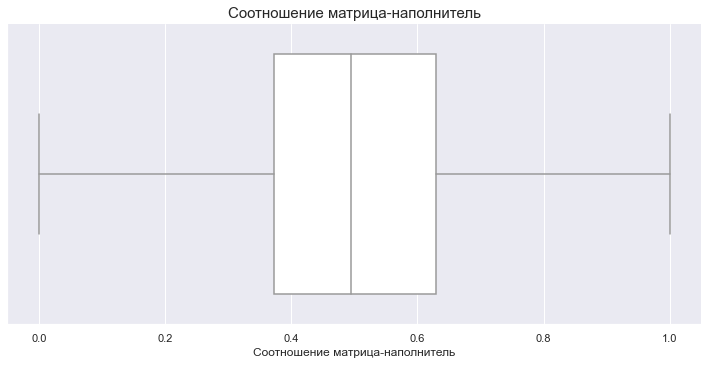

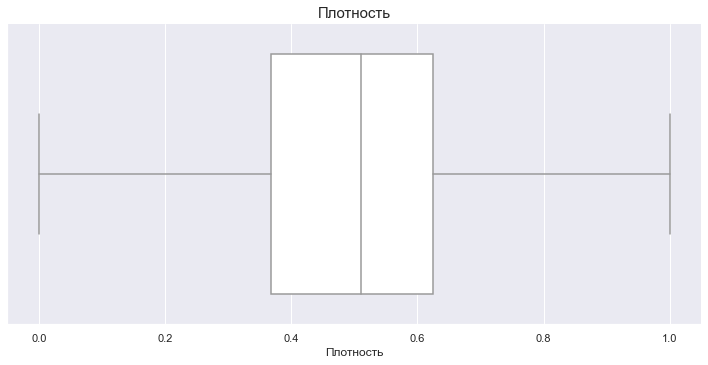

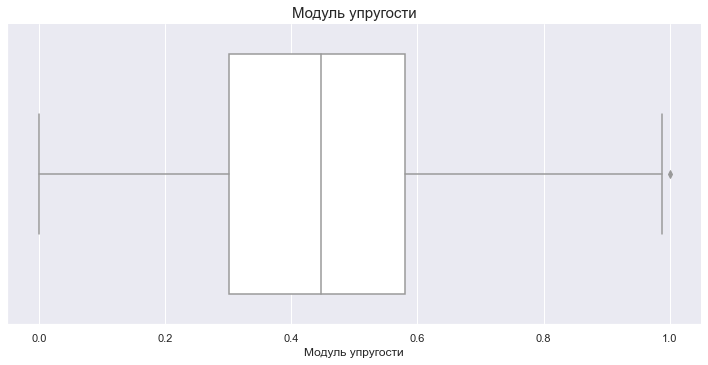

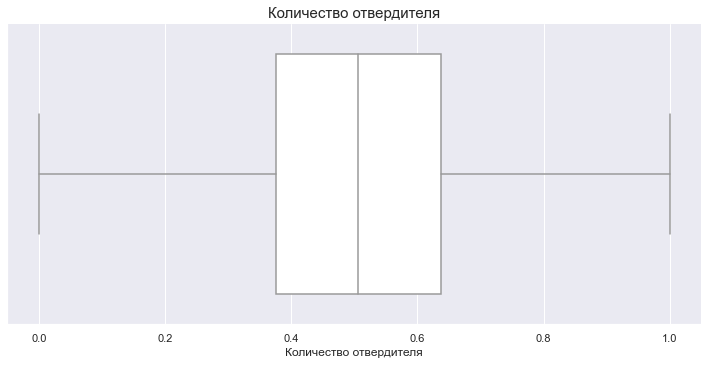

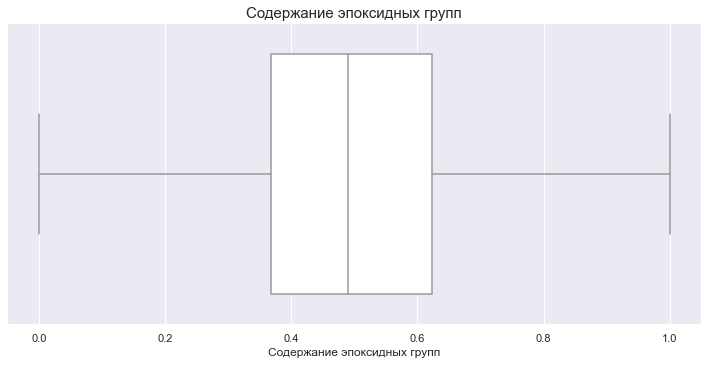

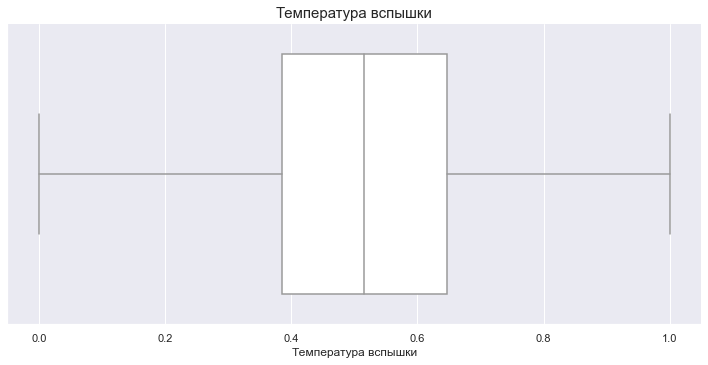

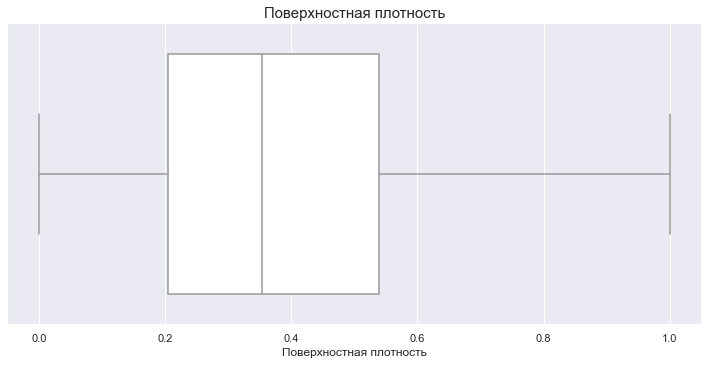

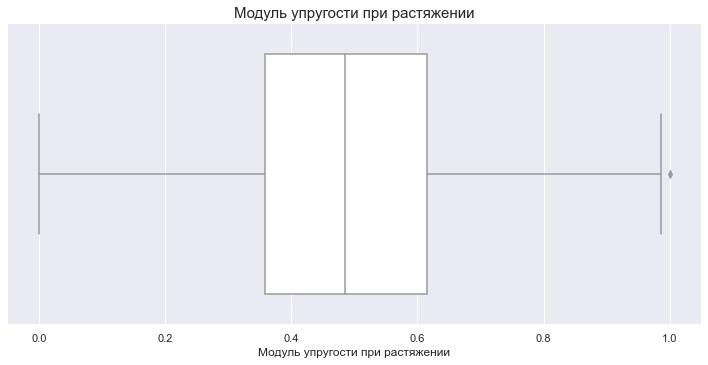

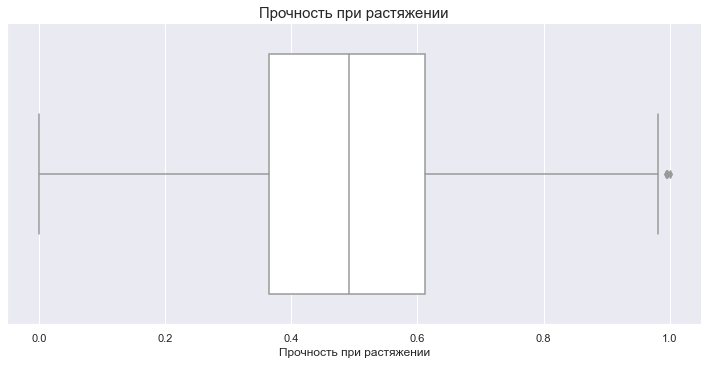

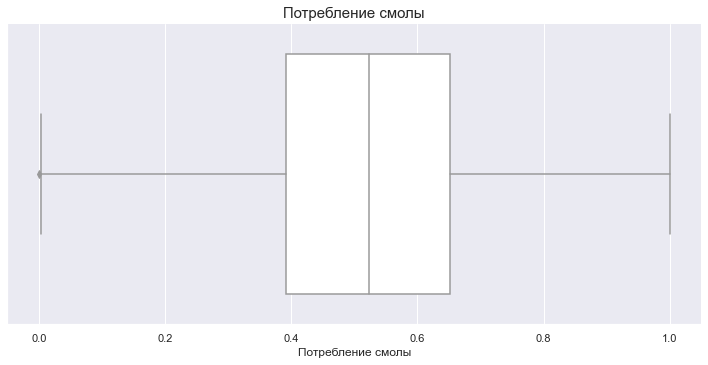

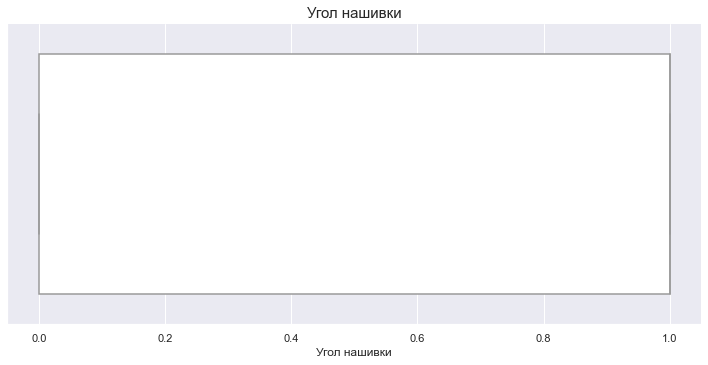

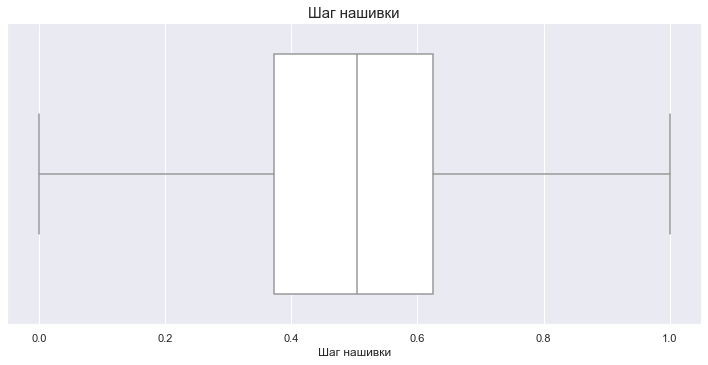

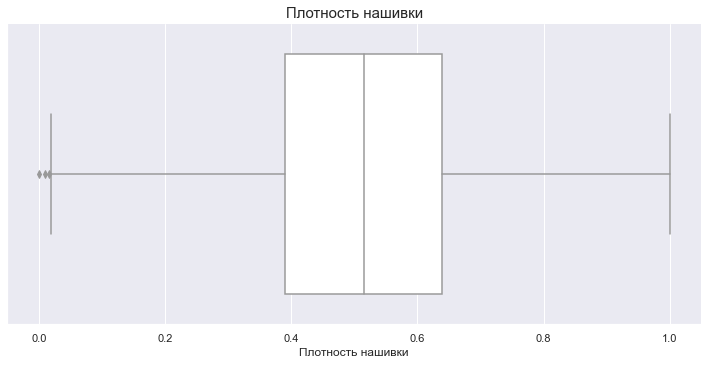

In [23]:
for col in df_norm.columns:
    sns.catplot(x=col, data=df_norm, kind='box', color='white', aspect=1*2)
    plt.title(col, fontsize=15)

### Повторяем график распределения

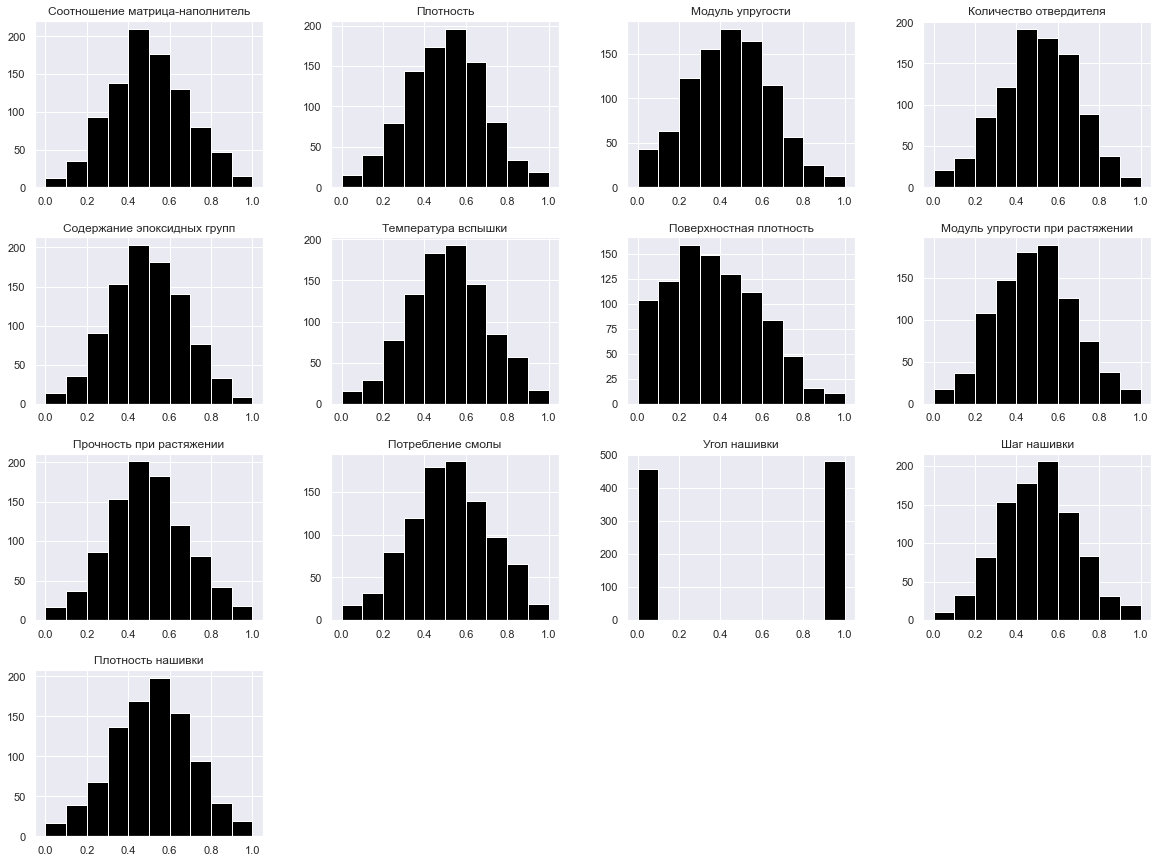

In [24]:
df_norm.hist(figsize=(20,15), color='black');

# Подготовка моделей

### Создание

In [25]:
X_1 = df_norm.drop(['Модуль упругости при растяжении'], axis=1)

Y_1 = df_norm['Модуль упругости при растяжении']

X_1.head()

Соотношение матрица-наполнитель  Плотность  Модуль упругости  \
0                         0.274768   0.651097          0.447061   
1                         0.274768   0.651097          0.447061   
2                         0.466552   0.651097          0.455721   
3                         0.465836   0.571539          0.452685   
4                         0.424236   0.332865          0.488508   

   Количество отвердителя  Содержание эпоксидных групп  Температура вспышки  \
0                0.079153                     0.607435             0.509164   
1                0.630983                     0.418887             0.583596   
2                0.511257                     0.495653             0.509164   
3                0.511257                     0.495653             0.509164   
4                0.511257                     0.495653             0.509164   

   Поверхностная плотность  Прочность при растяжении  Потребление смолы  \
0                  0.16223                   0.71259           0.529221   
1                  0.16223                   0.71259           0.529221   
2                  0.16223                   0.71259           0.529221   
3                  0.16223                   0.71259           0.529221   
4                  0.16223                   0.71259           0.529221   

   Угол нашивки  Шаг нашивки  Плотность нашивки  
0           0.0     0.289334           0.557156  
1           0.0     0.362355           0.335840  
2           0.0     0.362355           0.506083  
3           0.0     0.362355           0.557156  
4           0.0     0.362355           0.727399

In [26]:
X_2 = df_norm.drop(['Прочность при растяжении'], axis=1)

Y_2 = df_norm['Прочность при растяжении']

X_2.head()

Соотношение матрица-наполнитель  Плотность  Модуль упругости  \
0                         0.274768   0.651097          0.447061   
1                         0.274768   0.651097          0.447061   
2                         0.466552   0.651097          0.455721   
3                         0.465836   0.571539          0.452685   
4                         0.424236   0.332865          0.488508   

   Количество отвердителя  Содержание эпоксидных групп  Температура вспышки  \
0                0.079153                     0.607435             0.509164   
1                0.630983                     0.418887             0.583596   
2                0.511257                     0.495653             0.509164   
3                0.511257                     0.495653             0.509164   
4                0.511257                     0.495653             0.509164   

   Поверхностная плотность  Модуль упругости при растяжении  \
0                  0.16223                         0.280303   
1                  0.16223                         0.280303   
2                  0.16223                         0.280303   
3                  0.16223                         0.280303   
4                  0.16223                         0.280303   

   Потребление смолы  Угол нашивки  Шаг нашивки  Плотность нашивки  
0           0.529221           0.0     0.289334           0.557156  
1           0.529221           0.0     0.362355           0.335840  
2           0.529221           0.0     0.362355           0.506083  
3           0.529221           0.0     0.362355           0.557156  
4           0.529221           0.0     0.362355           0.727399

In [27]:
X_3 = df_norm.drop(['Соотношение матрица-наполнитель'], axis=1)
X_3_median = df_norm_median.drop(['Соотношение матрица-наполнитель'], axis=1)

Y_3 = df_norm['Соотношение матрица-наполнитель']
Y_3_median = df_norm_median['Соотношение матрица-наполнитель']

X_3.head()

Плотность  Модуль упругости  Количество отвердителя  \
0   0.651097          0.447061                0.079153   
1   0.651097          0.447061                0.630983   
2   0.651097          0.455721                0.511257   
3   0.571539          0.452685                0.511257   
4   0.332865          0.488508                0.511257   

   Содержание эпоксидных групп  Температура вспышки  Поверхностная плотность  \
0                     0.607435             0.509164                  0.16223   
1                     0.418887             0.583596                  0.16223   
2                     0.495653             0.509164                  0.16223   
3                     0.495653             0.509164                  0.16223   
4                     0.495653             0.509164                  0.16223   

   Модуль упругости при растяжении  Прочность при растяжении  \
0                         0.280303                   0.71259   
1                         0.280303                   0.71259   
2                         0.280303                   0.71259   
3                         0.280303                   0.71259   
4                         0.280303                   0.71259   

   Потребление смолы  Угол нашивки  Шаг нашивки  Плотность нашивки  
0           0.529221           0.0     0.289334           0.557156  
1           0.529221           0.0     0.362355           0.335840  
2           0.529221           0.0     0.362355           0.506083  
3           0.529221           0.0     0.362355           0.557156  
4           0.529221           0.0     0.362355           0.727399

### Разделение на тренировочную и тестовую части

In [28]:
X_1_train, X_1_test, Y_1_train, Y_1_test = train_test_split(X_1, Y_1, test_size = 0.3, random_state=42)

X_2_train, X_2_test, Y_2_train, Y_2_test = train_test_split(X_2, Y_2, test_size = 0.3, random_state=42)

X_3_train, X_3_test, Y_3_train, Y_3_test = train_test_split(X_3, Y_3, test_size = 0.3, random_state=42)
X_3_train_median, X_3_test_median, Y_3_train_median, Y_3_test_median = train_test_split(X_3_median, Y_3_median, test_size = 0.3, random_state=42)

### Создание модели, выдающей среднее значение для сравнения

In [29]:
def mean_model(test_model):
    return [np.mean(test_model) for _ in range(len(test_model))]

Y_1_predict_mean = mean_model(Y_1_test)
Y_2_predict_mean = mean_model(Y_2_test)

# Обучение моделей

## Прогноз модуля упругости при растяжении

**Linear Regressor**

In [30]:
slr = LinearRegression()

slr.fit(X_1_train, Y_1_train)
Y_1_train_predict = slr.predict(X_1_train)
Y_1_test_predict = slr.predict(X_1_test)

df_lin = pd.DataFrame({'Actual': Y_1_test, 'Predicted': Y_1_test_predict})
df_lin.head()

Actual  Predicted
321  0.773607   0.476773
70   0.228714   0.499995
209  0.364619   0.517926
656  0.775536   0.503051
685  0.303287   0.490986

In [31]:
round(mean_squared_error(Y_1_test, Y_1_test_predict), 6)

0.034808

In [32]:
round(r2_score(Y_1_test, Y_1_test_predict), 6)

-0.005222

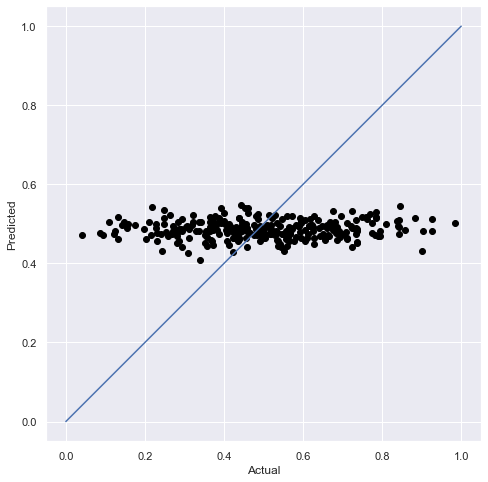

In [33]:
plt.axes(aspect='equal')
plt.scatter(Y_1_test, Y_1_test_predict, color='black')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.plot([0, 1],[0, 1]);

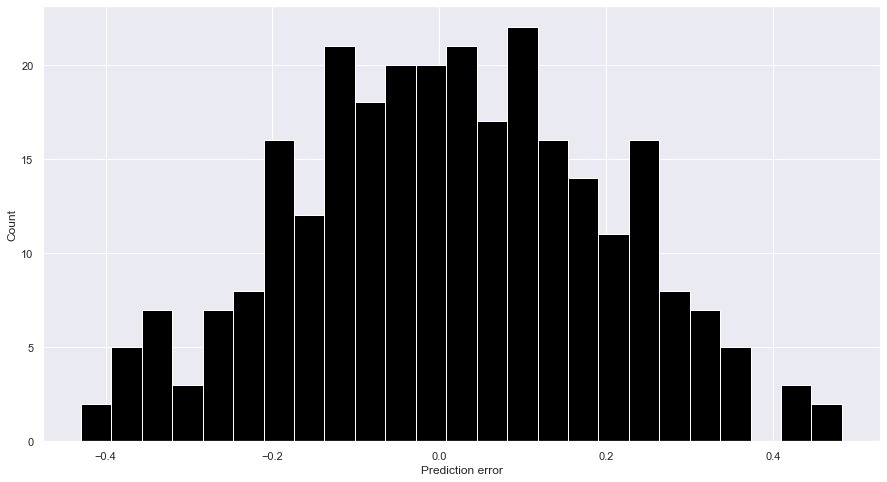

In [34]:
# график распределения ошибки

error = Y_1_test - Y_1_test_predict
plt.hist(error, bins = 25, color='black')
plt.xlabel('Prediction error')
plt.ylabel('Count');

**Сравнение с результатом модели, выдающей среднее значение целевой переменной из тестовой выборки**

In [35]:
round(mean_squared_error(Y_1_test, Y_1_predict_mean), 6)

0.034627

In [36]:
round(r2_score(Y_1_test, Y_1_predict_mean), 6)

0.0

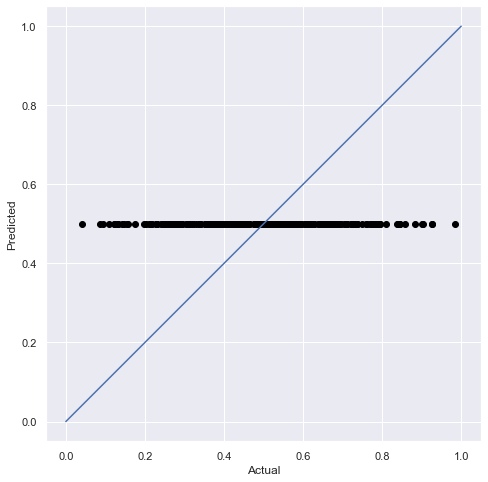

In [37]:
plt.axes(aspect='equal')
plt.scatter(Y_1_test, Y_1_predict_mean, color='black')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.plot([0, 1],[0, 1]);

**Decision Tree Regressor**

In [38]:
dtr = DecisionTreeRegressor(random_state=1)

parameters_dtr = {'max_depth': range (1,7),    
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }

grid_dtr = GridSearchCV(dtr, parameters_dtr, cv=10)
grid_dtr.fit(X_1_train, Y_1_train)

grid_dtr.best_params_

{'max_depth': 1, 'min_samples_leaf': 6, 'min_samples_split': 2}

In [39]:
decision_tree_model = DecisionTreeRegressor(max_depth = 1, min_samples_leaf = 6, min_samples_split = 2, random_state=1)
decision_tree_model.fit(X_1_train, Y_1_train)
Y_predict_tree = decision_tree_model.predict(X_1_test)

round(mean_squared_error(Y_1_test, Y_predict_tree), 6)

0.034693

In [40]:
round(r2_score(Y_1_test, Y_predict_tree), 6)

-0.001902

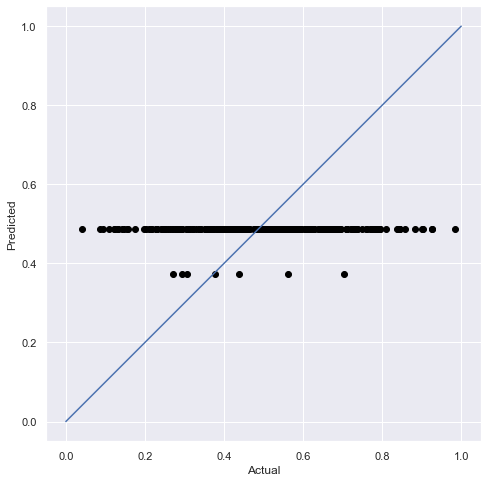

In [41]:
plt.axes(aspect='equal')
plt.scatter(Y_1_test, Y_predict_tree, color='black')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.plot([0, 1],[0, 1]);

**Random Forest Regressor**

In [42]:
rfr = RandomForestRegressor()

parametrs_rfr = { 'n_estimators': range (10, 51, 5),
              'max_depth': range (1,7),
              'min_samples_leaf': range (1,8)}

grid_rfr = GridSearchCV(rfr, parametrs_rfr, cv=10)
grid_rfr.fit(X_1_train, Y_1_train)

grid_rfr.best_params_

{'max_depth': 1, 'min_samples_leaf': 2, 'n_estimators': 10}

In [43]:
rand_forest_model = RandomForestRegressor(n_estimators = 15, max_depth = 1, min_samples_leaf = 7, min_samples_split=4)
rand_forest_model.fit(X_1_train, Y_1_train)
Y_predict_forest = rand_forest_model.predict(X_1_test)

round(mean_squared_error(Y_1_test, Y_predict_forest), 6)

0.034793

In [44]:
round(r2_score(Y_1_test, Y_predict_forest), 6)

-0.004805

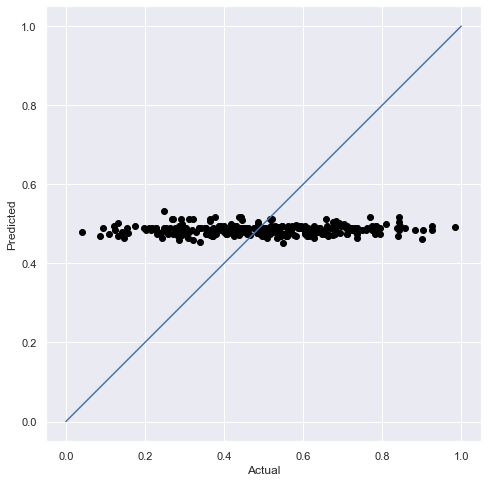

In [45]:
plt.axes(aspect='equal')
plt.scatter(Y_1_test, Y_predict_forest, color='black')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.plot([0, 1],[0, 1]);

**Gradient Boosting Regressor**

In [46]:
gbr = GradientBoostingRegressor()

parameters_gbr = {'n_estimators': range (30, 51, 10),
              'max_depth': range (1,2),
              'min_samples_leaf': range (1,5)}

grid_gbr = GridSearchCV(gbr, parameters_gbr, cv=10)
grid_gbr.fit(X_1_train, Y_1_train)

grid_gbr.best_params_

{'max_depth': 1, 'min_samples_leaf': 1, 'n_estimators': 30}

In [85]:
gradient_boosting_model = GradientBoostingRegressor(n_estimators = 50, max_depth = 1, min_samples_leaf = 3)
gradient_boosting_model.fit(X_1_train, Y_1_train)
Y_predict_boosting = gradient_boosting_model.predict(X_1_test)

round(mean_squared_error(Y_1_test, Y_predict_boosting), 6)

0.034329

In [84]:
round(r2_score(Y_1_test, Y_predict_boosting), 6)

0.00862

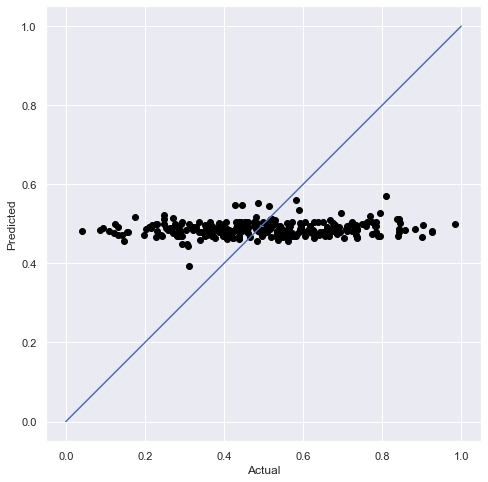

In [49]:
plt.axes(aspect='equal')
plt.scatter(Y_1_test, Y_predict_boosting, color='black')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.plot([0, 1],[0, 1]);

**Сравнение MSE:**

In [50]:
mse_compare = pd.DataFrame({'Model': ['Linear Regressor', 'Decision Tree Regressor', 'Random Forest Regressor',
                                     'Gradient Boosting Regressor', 'Mean Function'], 
                            'MSE': [0.034808, 0.034693, 0.034701, 0.034329, 0.034627]}).sort_values('MSE', axis=0, ascending=True, inplace=False)
mse_compare

Model       MSE
3  Gradient Boosting Regressor  0.034329
4                Mean Function  0.034627
1      Decision Tree Regressor  0.034693
2      Random Forest Regressor  0.034701
0             Linear Regressor  0.034808

## Прогноз прочности при растяжении

**Linear Regressor**

In [51]:
slr = LinearRegression()

slr.fit(X_2_train, Y_2_train)
Y_2_train_predict = slr.predict(X_2_train)
Y_2_test_predict = slr.predict(X_2_test)

df_lin = pd.DataFrame({'Actual': Y_2_test, 'Predicted': Y_2_test_predict})
df_lin.head()

Actual  Predicted
321  0.233319   0.435826
70   0.613672   0.491103
209  0.635615   0.516908
656  0.551901   0.515739
685  0.321437   0.481831

In [52]:
round(mean_squared_error(Y_2_test, Y_2_test_predict), 6)

0.035449

In [53]:
round(r2_score(Y_2_test, Y_2_test_predict), 6)

-0.046999

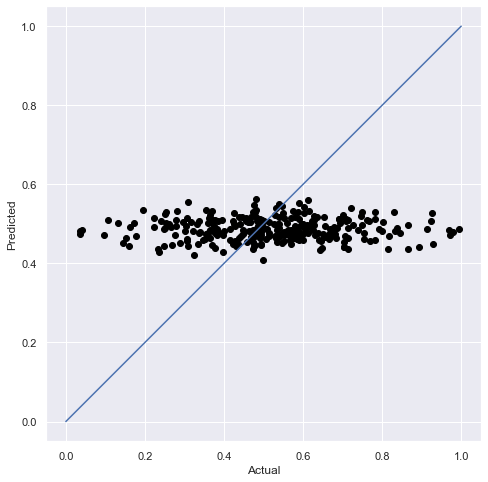

In [54]:
plt.axes(aspect='equal')
plt.scatter(Y_2_test, Y_2_test_predict, color='black')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.plot([0, 1],[0, 1]);

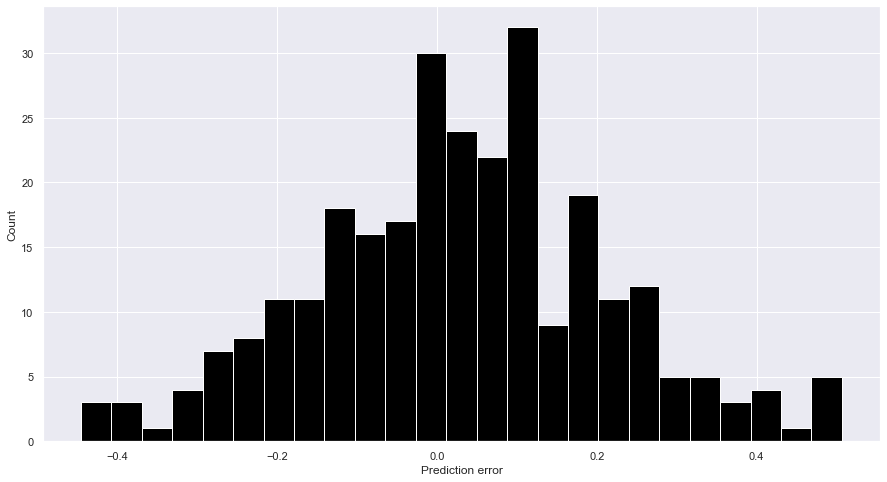

In [55]:
# график распределения ошибки

error = Y_2_test - Y_2_test_predict
plt.hist(error, bins = 25, color='black')
plt.xlabel('Prediction error')
plt.ylabel('Count');

**Сравнение с результатом модели, выдающей среднее значение целевой переменной из тестовой выборки**

In [56]:
round(mean_squared_error(Y_2_test, Y_2_predict_mean), 6)

0.033857

In [57]:
round(r2_score(Y_2_test, Y_2_predict_mean), 6)

-0.0

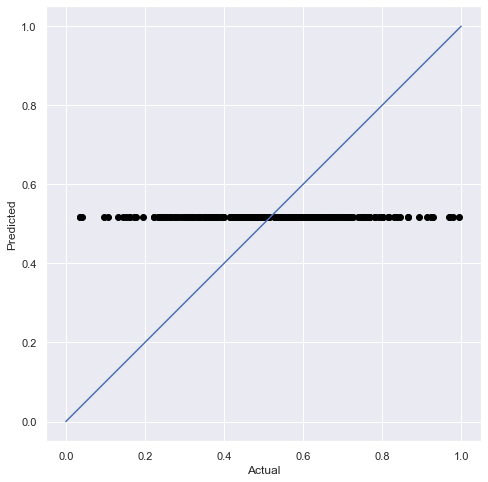

In [58]:
plt.axes(aspect='equal')
plt.scatter(Y_2_test, Y_2_predict_mean, color='black')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.plot([0, 1],[0, 1]);

**Decision Tree Regressor**

In [59]:
dtr = DecisionTreeRegressor(random_state=1)

parameters_dtr = {'max_depth': range (1,7),    
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }

grid_dtr = GridSearchCV(dtr, parameters_dtr, cv=10)
grid_dtr.fit(X_2_train, Y_2_train)

grid_dtr.best_params_

{'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [60]:
decision_tree_model = DecisionTreeRegressor(max_depth = 1, min_samples_leaf = 1, min_samples_split = 2, random_state=1)
decision_tree_model.fit(X_2_train, Y_2_train)
Y_predict_tree = decision_tree_model.predict(X_2_test)

round(mean_squared_error(Y_2_test, Y_predict_tree), 6)

0.035352

In [61]:
round(r2_score(Y_2_test, Y_predict_tree), 6)

-0.044133

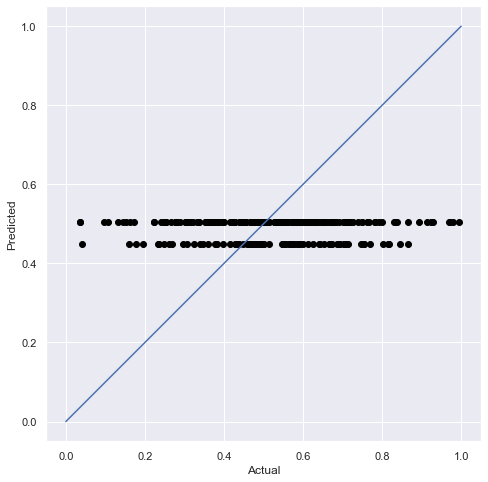

In [62]:
plt.axes(aspect='equal')
plt.scatter(Y_2_test, Y_predict_tree, color='black')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.plot([0, 1],[0, 1]);

**Random Forest Regressor**

In [63]:
rfr = RandomForestRegressor()

parametrs_rfr = { 'n_estimators': range (10, 31, 10),
              'max_depth': range (1,7),
              'min_samples_leaf': range (1,8)}

grid_rfr = GridSearchCV(rfr, parametrs_rfr, cv=10)
grid_rfr.fit(X_2_train, Y_2_train)

grid_rfr.best_params_

{'max_depth': 1, 'min_samples_leaf': 5, 'n_estimators': 10}

In [64]:
rand_forest_model = RandomForestRegressor(n_estimators = 10, max_depth = 1, min_samples_leaf = 1)
rand_forest_model.fit(X_2_train, Y_2_train)
Y_predict_forest = rand_forest_model.predict(X_2_test)

round(mean_squared_error(Y_2_test, Y_predict_forest), 6)

0.035063

In [65]:
round(r2_score(Y_2_test, Y_predict_forest), 6)

-0.035611

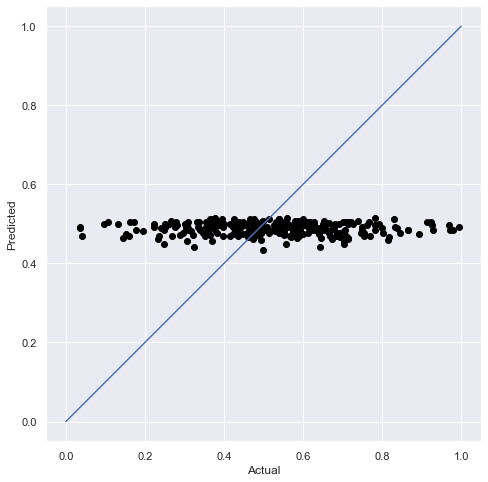

In [66]:
plt.axes(aspect='equal')
plt.scatter(Y_2_test, Y_predict_forest, color='black')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.plot([0, 1],[0, 1]);

**Gradient Boosting Regressor**

In [67]:
gbr = GradientBoostingRegressor()

parameters_gbr = {'n_estimators': range (30, 51, 10),
              'max_depth': range (1,2),
              'min_samples_leaf': range (1,5)}

grid_gbr = GridSearchCV(gbr, parameters_gbr, cv=10)
grid_gbr.fit(X_2_train, Y_2_train)

grid_gbr.best_params_

{'max_depth': 1, 'min_samples_leaf': 3, 'n_estimators': 30}

In [86]:
gradient_boosting_model = GradientBoostingRegressor(n_estimators = 30, max_depth = 1, min_samples_leaf = 3)
gradient_boosting_model.fit(X_1_train, Y_1_train)
Y_predict_boosting = gradient_boosting_model.predict(X_1_test)

round(mean_squared_error(Y_1_test, Y_predict_boosting), 6)

0.034368

In [69]:
round(r2_score(Y_2_test, Y_predict_boosting), 6)

-0.033789

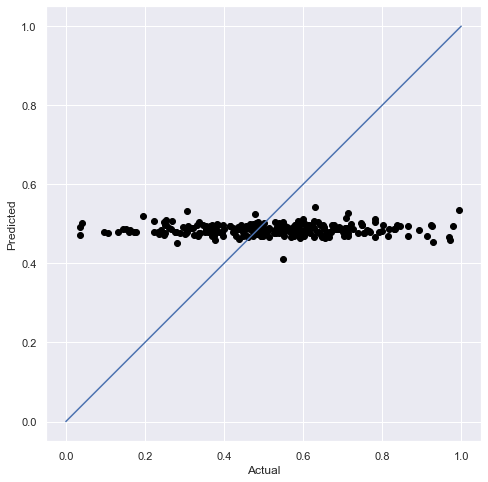

In [70]:
plt.axes(aspect='equal')
plt.scatter(Y_2_test, Y_predict_boosting, color='black')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.plot([0, 1],[0, 1]);

**Сравнение MSE:**

In [87]:
mse_compare = pd.DataFrame({'Model': ['Linear Regressor', 'Decision Tree Regressor', 'Random Forest Regressor',
                                     'Gradient Boosting Regressor', 'Mean Function'], 
                            'MSE': [0.035449, 0.035352, 0.035164, 0.034368, 0.033857]}).sort_values('MSE', axis=0, ascending=True, inplace=False)
mse_compare

Model       MSE
4                Mean Function  0.033857
3  Gradient Boosting Regressor  0.034368
2      Random Forest Regressor  0.035164
1      Decision Tree Regressor  0.035352
0             Linear Regressor  0.035449

## Прогноз соотношения матрица-наполнитель

In [72]:
n_model = keras.Sequential([
    layers.Dense(12, activation = 'relu', input_dim=12),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(1),
])

# изменение количества слоев и нейронов выше данных значение практически не показало изменения результата

In [73]:
n_model.compile(optimizer='SGD',
             loss='mse',
             metrics='mse')

# оптимайзеры Adam, RMSProp показали результаты хуже и были склонны к переобучению (например, Adam увеличивал MSE на тестовой
# выборке уже начиная с 15 эпохи)

In [74]:
n_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                156       
                                                                 
 dense_1 (Dense)             (None, 128)               1664      
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 14,301
Trainable params: 14,301
Non-trainable params: 0
_________________________________________________________________


In [75]:
history = n_model.fit(X_3_train, Y_3_train, epochs=100, validation_split = 0.3)

# результаты остаются стабильными и при прохождении 500 эпох

Epoch 1/100
15/15 [==============================] - 1s 14ms/step - loss: 0.1779 - mse: 0.1779 - val_loss: 0.0551 - val_mse: 0.0551
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0463 - mse: 0.0463 - val_loss: 0.0379 - val_mse: 0.0379
Epoch 3/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0384 - mse: 0.0384 - val_loss: 0.0376 - val_mse: 0.0376
Epoch 4/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0380 - mse: 0.0380 - val_loss: 0.0376 - val_mse: 0.0376
Epoch 5/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0377 - mse: 0.0377 - val_loss: 0.0374 - val_mse: 0.0374
Epoch 6/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0377 - mse: 0.0377 - val_loss: 0.0377 - val_mse: 0.0377
Epoch 7/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0375 - mse: 0.0375 - val_loss: 0.0375 - val_mse: 0.0375
Epoch 8/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0373 - 

15/15 [==============================] - 0s 3ms/step - loss: 0.0354 - mse: 0.0354 - val_loss: 0.0361 - val_mse: 0.0361
Epoch 64/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0355 - mse: 0.0355 - val_loss: 0.0367 - val_mse: 0.0367
Epoch 65/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0355 - mse: 0.0355 - val_loss: 0.0364 - val_mse: 0.0364
Epoch 66/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0354 - mse: 0.0354 - val_loss: 0.0361 - val_mse: 0.0361
Epoch 67/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0354 - mse: 0.0354 - val_loss: 0.0359 - val_mse: 0.0359
Epoch 68/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0353 - mse: 0.0353 - val_loss: 0.0362 - val_mse: 0.0362
Epoch 69/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0353 - mse: 0.0353 - val_loss: 0.0360 - val_mse: 0.0360
Epoch 70/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0353 - mse: 0

In [76]:
n_model.evaluate(X_3_test, Y_3_test, verbose=1)

9/9 [==============================] - 0s 1ms/step - loss: 0.0338 - mse: 0.0338


[0.03383169323205948, 0.03383169323205948]

In [77]:
n_model.save("neural_net")

INFO:tensorflow:Assets written to: neural_net\assets


In [78]:
predict_model =  n_model.predict(X_3_test)
predict_values = np.ravel(predict_model) 
predict_values

array([0.508, 0.509, 0.523, 0.504, 0.469, 0.506, 0.485, 0.519, 0.491,
       0.566, 0.508, 0.579, 0.54 , 0.498, 0.487, 0.503, 0.485, 0.488,
       0.512, 0.506, 0.488, 0.513, 0.501, 0.505, 0.548, 0.531, 0.498,
       0.487, 0.509, 0.523, 0.495, 0.502, 0.467, 0.496, 0.498, 0.479,
       0.497, 0.514, 0.501, 0.486, 0.499, 0.607, 0.499, 0.48 , 0.524,
       0.508, 0.504, 0.577, 0.504, 0.499, 0.528, 0.532, 0.513, 0.491,
       0.5  , 0.476, 0.529, 0.538, 0.496, 0.523, 0.478, 0.49 , 0.498,
       0.481, 0.501, 0.505, 0.482, 0.489, 0.533, 0.503, 0.505, 0.516,
       0.544, 0.516, 0.509, 0.534, 0.51 , 0.55 , 0.533, 0.515, 0.57 ,
       0.472, 0.488, 0.486, 0.539, 0.556, 0.5  , 0.503, 0.517, 0.494,
       0.547, 0.576, 0.494, 0.537, 0.54 , 0.528, 0.552, 0.512, 0.484,
       0.537, 0.511, 0.513, 0.497, 0.505, 0.508, 0.509, 0.495, 0.497,
       0.473, 0.502, 0.498, 0.563, 0.555, 0.584, 0.516, 0.529, 0.513,
       0.512, 0.497, 0.483, 0.492, 0.509, 0.498, 0.51 , 0.477, 0.484,
       0.497, 0.549,

In [79]:
Y_3_test_values = np.ravel(Y_3_test.copy())
Y_3_test_values

array([0.488, 0.292, 0.246, 0.851, 0.611, 0.448, 0.205, 0.63 , 0.425,
       0.384, 0.315, 0.399, 0.6  , 0.411, 0.616, 0.535, 0.39 , 0.34 ,
       0.209, 0.471, 0.346, 0.742, 0.662, 0.511, 0.419, 0.865, 0.27 ,
       0.578, 0.789, 0.532, 0.433, 0.418, 0.136, 0.313, 0.51 , 0.619,
       0.705, 0.199, 0.672, 0.715, 0.448, 0.417, 0.519, 0.245, 0.336,
       0.436, 0.606, 0.522, 0.801, 0.443, 0.712, 0.449, 0.59 , 0.405,
       0.275, 0.58 , 0.996, 0.393, 0.595, 0.817, 0.088, 0.524, 0.825,
       0.588, 0.198, 0.497, 0.636, 0.252, 0.095, 0.728, 0.404, 0.651,
       0.554, 0.492, 0.479, 0.815, 0.52 , 0.333, 0.477, 0.306, 0.428,
       0.319, 0.671, 0.462, 0.292, 0.491, 0.209, 0.36 , 0.773, 0.453,
       0.321, 0.589, 0.451, 0.336, 0.835, 0.243, 0.267, 0.263, 0.551,
       0.811, 0.594, 0.281, 0.305, 0.51 , 0.442, 0.804, 0.513, 0.464,
       0.737, 0.663, 0.556, 0.631, 0.513, 0.48 , 0.674, 0.34 , 0.346,
       0.448, 0.375, 0.515, 0.362, 0.606, 0.75 , 0.597, 0.376, 0.268,
       0.444, 0.347,

**График рассеяния. В идеальном случае он должен быть похож на прямую линию**

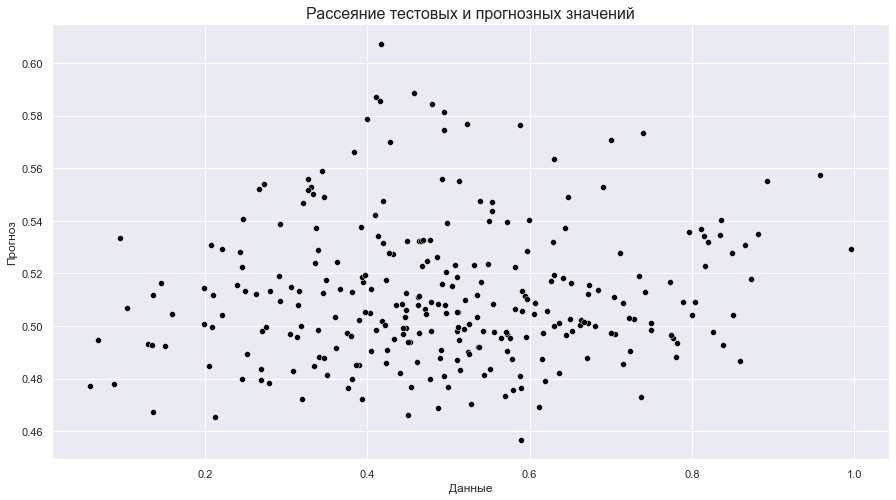

Данные   Прогноз
0    0.487579  0.508204
1    0.292155  0.509448
2    0.245958  0.522566
3    0.850789  0.504228
4    0.611147  0.469178
..        ...       ...
276  0.528359  0.470481
277  0.440618  0.482079
278  0.834572  0.534503
279  0.534751  0.511791
280  0.569121  0.473284

[281 rows x 2 columns]

In [80]:
feature_results = pd.DataFrame({'Данные': Y_3_test_values,'Прогноз': predict_values})
sns.set_style('darkgrid')
plt.title('Рассеяние тестовых и прогнозных значений',size=16)
plt.xlabel('Данные',size=12)
plt.ylabel('Прогноз',size=12)
sns.scatterplot(x='Данные', y='Прогноз', data=feature_results, color="black")
plt.show()
feature_results

**Попробуем эту же нейросеть на выборке с медианными значениями вместо выбросов**

In [81]:
history_median = n_model.fit(X_3_train_median, Y_3_train_median, epochs=100, validation_split = 0.3)

Epoch 1/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0347 - mse: 0.0347 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 0.0346 - mse: 0.0346 - val_loss: 0.0324 - val_mse: 0.0324
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 0.0346 - mse: 0.0346 - val_loss: 0.0324 - val_mse: 0.0324
Epoch 4/100
16/16 [==============================] - 0s 4ms/step - loss: 0.0345 - mse: 0.0345 - val_loss: 0.0324 - val_mse: 0.0324
Epoch 5/100
16/16 [==============================] - 0s 3ms/step - loss: 0.0345 - mse: 0.0345 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 6/100
16/16 [==============================] - 0s 3ms/step - loss: 0.0346 - mse: 0.0346 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 7/100
16/16 [==============================] - 0s 3ms/step - loss: 0.0346 - mse: 0.0346 - val_loss: 0.0323 - val_mse: 0.0323
Epoch 8/100
16/16 [==============================] - 0s 3ms/step - loss: 0.0345 - m

16/16 [==============================] - 0s 3ms/step - loss: 0.0343 - mse: 0.0343 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 64/100
16/16 [==============================] - 0s 3ms/step - loss: 0.0343 - mse: 0.0343 - val_loss: 0.0324 - val_mse: 0.0324
Epoch 65/100
16/16 [==============================] - 0s 3ms/step - loss: 0.0343 - mse: 0.0343 - val_loss: 0.0324 - val_mse: 0.0324
Epoch 66/100
16/16 [==============================] - 0s 3ms/step - loss: 0.0343 - mse: 0.0343 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 67/100
16/16 [==============================] - 0s 3ms/step - loss: 0.0342 - mse: 0.0342 - val_loss: 0.0324 - val_mse: 0.0324
Epoch 68/100
16/16 [==============================] - 0s 3ms/step - loss: 0.0343 - mse: 0.0343 - val_loss: 0.0324 - val_mse: 0.0324
Epoch 69/100
16/16 [==============================] - 0s 3ms/step - loss: 0.0343 - mse: 0.0343 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 70/100
16/16 [==============================] - 0s 3ms/step - loss: 0.0342 - mse: 0

In [82]:
n_model.evaluate(X_3_test_median, Y_3_test_median, verbose=1)

10/10 [==============================] - 0s 1ms/step - loss: 0.0366 - mse: 0.0366


[0.036648865789175034, 0.036648865789175034]